# 3. Cluster Analysis

This notebook performs a cluster analysis on the data set df_trips based on various parameters and also includes clustering based on weather and spatial features.

**Task** <br>
Getting a deep understanding of how customers use your mobility service is crucial.
As an example, for marketing purposes, or managerial decisions. One widely adopted approach to
understand customers’ behavior is to find prevalent usage/trip clusters. Tasks: Based on the taxi trip
patterns, can you identify clusters of trip types and/or customer types? How would you label these
clusters? Methods: Identify clusters with soft-clustering and visualize your results. Compare your
results to a hard-clustering method of your choice. You can use additional features like “distance to city
center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI
data.
Furthermore, can you identify spatial hot spots for trip demand using Gaussian Mixture Models (i.e.,
using Spatial Kernel Density Estimation)?

**Structure**
1. trips
2. weather-based
3. spatial


### Imports

In [546]:
import vaex
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import folium
import seaborn as sns

import geopandas as gpd

import h3
from shapely.geometry.polygon import Polygon
from shapely.geometry.point import Point

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [547]:
import warnings
warnings.filterwarnings('ignore')

### Defines

In [548]:
# hex resolution
HEX_RES = 9
# test mode
TEST_MODE = False

## Helper Methods
Collection of helper methods for various repetitive tasks. The collection is structured by the category of the method as followed:
1. Data Cleaning
2. Clustering Helper
3. Data Visualization and Evaluation


#### 1. Data cleaning and preparation
Collection of methods used for data cleaning on all datasets. The main functionality is to remove Nan values and to replace outliers in the dataset.

In [565]:
def outlier_thresholds(dataframe, feature):
    """
    Method to find outlier in a feature
    Returns the lower and upper limit
    """
    lower_quantile = dataframe[feature].quantile(0.10)
    upper_quantile = dataframe[feature].quantile(0.90)
    interquantile_range = upper_quantile - lower_quantile
    up_limit  = upper_quantile + 1.5 * interquantile_range
    low_limit = lower_quantile - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, feature):
    """
    Method to replace outlier in a feature.
    It replaces outliers by the lower or upper limit.    
    """
    low_limit, up_limit = outlier_thresholds(dataframe, feature)
    dataframe.loc[(dataframe[feature] < low_limit), feature] = low_limit
    dataframe.loc[(dataframe[feature] > up_limit), feature] = up_limit

def remove_all_outliers(dataframe):
    """
    Method to iterate over all columns of a dataframe to replace all outliers
    """
    for col in dataframe.select_dtypes([np.number]).columns:
        dataframe[col].fillna(0, inplace=True)
        replace_with_thresholds(dataframe, col)

In [550]:
def scale_df(dataframe):
    scaler = StandardScaler()
    scaler.fit(dataframe)
    dataframe_scaled = scaler.transform(dataframe)

    scaled_df = pd.DataFrame(dataframe_scaled, columns = dataframe.columns, index = dataframe.index)

    return scaled_df

#### 2. Clustering Helper
Collection of methods to encapsulate repetitive tasks during the clustering (e.g. Scaling, GridSearch, fitting, prediction)

In [551]:
def gridSearch(scaled_dataframe, n_clusters_max = 6):
    """
    Method that performs a grid search with the given model and plots the results.
    """
    clusters = []
    losses = []

    for k in range(n_clusters_max):
        model = KMeans(n_clusters = k + 1, n_init=10, init="k-means++", random_state=42)
        model.fit(scaled_dataframe)
        clusters.append(k+1)
        losses.append(model.inertia_)
        
    # plot grid search result
    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.show()

In [552]:
def fit_and_predict(model, scaled_dataframe, dataframe):
    model.fit(scaled_dataframe)
    dataframe[f'cluster_{model.__class__.__name__}'] =  model.predict(scaled_dataframe)

#### 3. Data Visualization and Evaluation
Collection of methods to visualize the dataframe and the clustering results

In [553]:
def plt_corr(dataframe):
    """
    Method to plot a correlation matrix for the dataset.
    """
    base_df_corr = dataframe.corr()
    mask = np.triu(np.ones_like(base_df_corr, dtype=bool))
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figwidth(20)
    sns.heatmap(base_df_corr, annot = True, vmax= 1, vmin= -1, center=0, cmap='vlag', mask = mask)
    plt.show()

In [554]:
def feature_distribution(dataframe, cluster_column):
    """
    Method that returns a evaluation of each cluster including mean and std of each feature, the number of elements per cluster and the most frequent value per feature
    """
    # seperate feature columns
    feature_cols = list(filter(lambda x: not x.startswith('cluster'), dataframe.columns))
    # aggregate by cluster col
    feature_distribution_df = dataframe.groupby(cluster_column).agg(['mean', 'std'])[feature_cols]
    # add sizes
    feature_distribution_df["cluster_size"] = dataframe.groupby(cluster_column).size()
    # add value with the highest share
    value_frequencies =  dataframe.groupby(cluster_column).agg(lambda x:x.value_counts().index[0])
    for col in feature_cols:
        feature_distribution_df[f'first_{col}'] = value_frequencies[col]
    
    return feature_distribution_df

In [555]:
def plt_violins(dataframe):
        """
        Method to plot violin charts of the clustering results including a bar plot of the cluster sizes.
        """
 
        cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))
        feature_cols = list(filter(lambda x: not x.startswith('cluster'), dataframe.columns))

        fig, axes = plt.subplots(nrows = len(feature_cols) + 1, ncols = len(cluster_cols), figsize = (20,15))

        # iterate over all input features to plot the value distribution across the clusters  
        for cluster_id, cluster_col in enumerate(cluster_cols):
                for feature_id, feat in enumerate(feature_cols):
                        sns.violinplot(ax = axes[feature_id, cluster_id], x=dataframe[cluster_col], y=dataframe[feat], data=dataframe)
                        axes[feature_id, cluster_id].set_title(f'{cluster_col} - {feat}')
                # add cluster size to the plot
                cluster_size = dataframe.groupby(cluster_col).size()
                axes[len(feature_cols), cluster_id].bar(cluster_size.index, cluster_size)
                axes[len(feature_cols), cluster_id].set_title(f'{cluster_col} - Cluster Sizes')

        fig.tight_layout()
        plt.show()

In [556]:
def plt_cluster_size(dataframe):
        """
        Method to plot a bar plot of the cluster sizes.
        """
 
        cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))
        fig, axes = plt.subplots(nrows = 1, ncols = len(cluster_cols), figsize = (20,5))

        # iterate over all input features to plot the value distribution across the clusters  
        for cluster_id, cluster_col in enumerate(cluster_cols):
                # add cluster size to the plot
                cluster_size = dataframe.groupby(cluster_col).size()
                axes[cluster_id].bar(cluster_size.index, cluster_size)
                axes[cluster_id].set_title(f'{cluster_col} - Cluster Sizes')

        fig.tight_layout()
        plt.show()

In [557]:
def hex_to_map(dataframe):
    """
        Method to plot a map per cluster.
    """
    # create new dataframe with based on all cluster columns
    cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))    
    map_df = dataframe[cluster_cols]

    #convert hex to polygon
    map_df['hex'] = dataframe.index
    map_df = map_df[map_df.hex != 'None']
    map_df['geometry'] = map_df['hex'].apply(lambda id: Polygon(h3.cell_to_boundary(id, geo_json=True)))  
    

    # create geopandas dataframe
    map_gdf = gpd.GeoDataFrame(map_df[['geometry'] + cluster_cols ], crs='EPSG:4326')
    
    map = None

    for col in cluster_cols:
        map = map_gdf.explore(m = map, column = col, name = col)
    
    folium.LayerControl().add_to(map)
    
    return map    

In [558]:
 def plt_temporal_patterns(dataframe, no_cluster):
    """
        Method to plot temporal patterns.
    """
    cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))
   
    fig, ax = plt.subplots(nrows = len(cluster_cols), ncols = no_cluster, figsize=(20,16))
    
    for cluster in range(0, no_cluster):
        for idx, cluster_col in enumerate(cluster_cols):
            dataframe[dataframe[cluster_col] == cluster].drop(columns = cluster_cols).T.plot(ax=ax[idx, cluster], color='#8f3371', alpha=0.05)
            dataframe[dataframe[cluster_col] == cluster].drop(columns = cluster_cols).mean(numeric_only=True).T.plot(ax=ax[0, cluster], color = '#8f3371', alpha=1)
            ax[idx, cluster].get_legend().remove()
            ax[idx, cluster].set_title(f'{cluster_col} Cluster: {cluster}')
            ax[idx, cluster].set_xlim([0,23])
            ax[idx, cluster].set_xticks(np.arange(0,23))
    
    for idx, cluster_col in enumerate(cluster_cols):
        ax[idx, 0].set_ylabel('Number of Trips')

    plt.show()

## Data loading and preparation

1. Loading the data from different sources:
    - trip data
    - weather data
    - poi data
2. Selecting the relevant features and add additional features

### Trip data

In [559]:
# Load trip data from vaex df data/trips/trips_prepared.hdf
df_trips = vaex.open('data/trips/trips_prepared.hdf')

# for testing with reduced lines
if TEST_MODE:
    df_trips = df_trips.sample(n=100000, random_state=42)

In [560]:
df_trips.info()

#### Feature selection and conversion to pandas

In [561]:
# feature selection

features = ['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin', 'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin', 'start_1_hour_cos', 'Trip Seconds', 'Trip Total', f'pickup_hex_{HEX_RES}', f'dropoff_hex_{HEX_RES}', 'Payment Type_Cash', 'Payment Type_Credit Card']

# convert vaex to pandas dataframe
df_trips = df_trips[features].to_pandas_df()

#### Data cleaning

In [562]:
remove_all_outliers(df_trips)

In [563]:
df_trips = df_trips[df_trips[f'pickup_hex_{HEX_RES}']  != 'None']
df_trips = df_trips[df_trips[f'dropoff_hex_{HEX_RES}'] != 'None']

### Calculation of additional features
Calculation of hexagon based features as the distance to the center (location with the highest amount of ride starts) for Pickup and Dropoff and the direction of the ride (is the ride going to or away from the center). The measure is the number of hexagons.

In [564]:
# defining the city center by selecting the hexagon with the most pickups as center
center_hex = df_trips[f'pickup_hex_{HEX_RES}'].value_counts().idxmax()

print(f'Center hexagon: {center_hex}')

# calculate distances. Invalid hexagons result in 0.
df_trips['dist_center_pickup']  = df_trips.apply(lambda row: h3.grid_distance(row[f'pickup_hex_{HEX_RES}'] if h3.is_valid_cell(row[f'pickup_hex_{HEX_RES}']) else center_hex, center_hex), axis=1)
df_trips['dist_center_dropoff'] = df_trips.apply(lambda row: h3.grid_distance(row[f'dropoff_hex_{HEX_RES}'] if h3.is_valid_cell(row[f'dropoff_hex_{HEX_RES}']) else center_hex, center_hex), axis=1)

# direction -> negative values represent trips going away from the center whereas positive values represent trips to the center.
df_trips['direction']           = df_trips['dist_center_dropoff'] - df_trips['dist_center_pickup']                                                                    

Center hexagon: 892664c1a8bffff


KeyboardInterrupt: 

Calculation of additional time-based features

In [ ]:
# is_weekend: 1 for week end, 0 for weekdays
df_trips['is_weekend'] = np.where(df_trips['start_weekday'] >= 5, 1, 0)

In [ ]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0    2014-01-21 08:00:00          1.0              1           0.781831   
1    2014-02-01 22:00:00          2.0              5          -0.974928   
2    2014-11-14 23:00:00         11.0              4          -0.433884   
3    2014-03-16 11:00:00          3.0              6          -0.781831   
4    2014-03-21 22:00:00          3.0              4          -0.433884   
...                  ...          ...            ...                ...   
9995 2014-06-19 07:00:00          6.0              3           0.433884   
9996 2014-05-18 18:00:00          5.0              6          -0.781831   
9997 2014-05-16 23:00:00          5.0              4          -0.433884   
9998 2014-10-28 12:00:00         10.0              1           0.781831   
9999 2014-12-11 11:00:00         12.0              3           0.433884   

      start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0              0.623490           8.0      8.660254e-01     -5.000000e-01   
1             -0.222521          22.0     -5.000000e-01      8.660254e-01   
2             -0.900969          23.0     -2.588190e-01      9.659258e-01   
3              0.623490          11.0      2.588190e-01     -9.659258e-01   
4             -0.900969          22.0     -5.000000e-01      8.660254e-01   
...                 ...           ...               ...               ...   
9995          -0.900969           7.0      9.659258e-01     -2.588190e-01   
9996           0.623490          18.0     -1.000000e+00     -1.836970e-16   
9997          -0.900969          23.0     -2.588190e-01      9.659258e-01   
9998           0.623490          12.0      1.224647e-16     -1.000000e+00   
9999          -0.900969          11.0      2.588190e-01     -9.659258e-01   

      Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0            840.0        9.75  892664c1eabffff  892664c1e73ffff   
1           1108.0       15.25  892664ca913ffff  892664c80afffff   
2            600.0       10.65  892664c1e0fffff  892664c114fffff   
3              0.0        3.25  892664c1acfffff  892664c1acfffff   
4            360.0        7.55  892664c1e13ffff  892664c1e0fffff   
...            ...         ...              ...              ...   
9995         780.0       14.05  892664c1607ffff  892664c1ecfffff   
9996         249.0        8.05  892664cad77ffff  892664c1a8bffff   
9997         300.0        6.45  892664c1633ffff  892664c105bffff   
9998         480.0       10.65  892664c1b6fffff  892664c1ab3ffff   
9999         540.0       14.46  892664ca913ffff  892664c8cabffff   

      Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                   1.0                       0.0                   6   
1                   1.0                       0.0                   8   
2                   1.0                       0.0                   4   
3                   1.0                       0.0                   2   
4                   1.0                       0.0                   6   
...                 ...                       ...                 ...   
9995                1.0                       0.0                  25   
9996                0.0                       1.0                   7   
9997                1.0                       0.0                  24   
9998                0.0                       1.0                  12   
9999                0.0                       1.0                   8   

      dist_center_dropoff  direction  is_weekend  
0                       4         -2           0  
1                      32         24           1  
2                      12          8           0  
3                       2          0           1  
4                       4         -2           0  
...                   ...        ...         ...  
9995                    7        -18           0  
9996                    0         -7           1  
9997                   21     

### Weather data

In [ ]:
df_weather = pd.read_pickle('data/weather.pickle')

In [ ]:
df_weather.columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'Precip.', 'cloud', 'rain',
       'Fair', 'Fog', 'Snow', 'T-Storm', 'Thunder'],
      dtype='object')

In [ ]:
#weather_attributes = ['Temperature', 'Humidity', 'Wind Speed', 'Precip.', 'cloud', 'rain', 'Fair', 'Fog', 'Snow', 'T-Storm', 'Thunder']
weather_attributes = ['Temperature', 'Precip.', 'cloud']

df_weather = df_weather[weather_attributes]

In [ ]:
df_weather

Temperature  Precip.  cloud
datetime                                        
2014-01-01 00:00:00        -10.0      0.0    3.0
2014-01-01 01:00:00         -8.9      0.0    3.0
2014-01-01 02:00:00         -8.3      0.0    3.0
2014-01-01 03:00:00         -7.8      0.0    3.0
2014-01-01 04:00:00         -7.2      0.0    3.0
...                          ...      ...    ...
2014-12-31 19:00:00         -7.2      0.0    0.0
2014-12-31 20:00:00         -7.2      0.0    0.0
2014-12-31 21:00:00         -6.7      0.0    0.0
2014-12-31 22:00:00         -6.7      0.0    0.0
2014-12-31 23:00:00         -6.7      0.0    0.0

[8760 rows x 3 columns]

### POI data

In [ ]:
df_poi = pd.read_pickle('data/poi/poi_prepared.pickle')

In [ ]:
df_poi

amenity  \
osmid                         
258490031           parking   
269449042  parking_entrance   
269450074  parking_entrance   
269688947          post_box   
270863340  parking_entrance   
...                     ...   
13621412                NaN   
13621413                NaN   
13621414                NaN   
15910906                NaN   
15910907                NaN   

                                                    geometry name  \
osmid                                                               
258490031                         POINT (-87.64385 41.95123)  NaN   
269449042                         POINT (-87.61506 41.85869)  NaN   
269450074                         POINT (-87.58421 41.79174)  NaN   
269688947                         POINT (-87.77220 42.00407)  NaN   
270863340                         POINT (-87.61564 41.86421)  NaN   
...                                                      ...  ...   
13621412   POLYGON ((-87.66859 41.91735, -87.66895 41.917...  NaN   
13621413   POLYGON ((-87.66793 41.91671, -87.66797 41.916...  NaN   
13621414   POLYGON ((-87.66801 41.91728, -87.66800 41.917...  NaN   
15910906   POLYGON ((-87.62624 41.87979, -87.62623 41.879...  NaN   
15910907   POLYGON ((-87.62610 41.87984, -87.62610 41.880...  NaN   

                   category   latitude  longitude public_transport wheelchair  \
osmid                                                                           
258490031           parking  41.951227 -87.643847              NaN        NaN   
269449042           parking  41.858689 -87.615058              NaN        NaN   
269450074           parking  41.791742 -87.584208              NaN        NaN   
269688947             other  42.004073 -87.772198              NaN        NaN   
270863340           parking  41.864208 -87.615638              NaN        NaN   
...                     ...        ...        ...              ...        ...   
13621412   public_transport  41.917203 -87.668448         platform        NaN   
13621413   public_transport  41.917215 -87.668182         platform        NaN   
13621414   public_transport  41.917277 -87.668066         platform        NaN   
15910906   public_transport  41.879543 -87.626201         platform         no   
15910907   public_transport  41.879567 -87.626064         platform         no   

                     hex_7            hex_8            hex_9  \
osmid                                                          
258490031  872664c14ffffff  882664c145fffff  892664c144fffff   
269449042  872664c1bffffff  882664c1b1fffff  892664c1b03ffff   
269450074  872664cc5ffffff  882664cc59fffff  892664cc583ffff   
269688947  872664d9effffff  882664d9e1fffff  892664d9e0fffff   
270863340  872664c1bffffff  882664c1bdfffff  892664c1bc7ffff   
...                    ...              ...              ...   
13621412   872664c12ffffff  882664cac9fffff  892664cac93ffff   
13621413   872664c12ffffff  882664cac9fffff  892664cac93ffff   
13621414   872664c12ffffff  882664cac9fffff  892664cac93ffff   
15910906   872664c1affffff  882664c1a9fffff  892664c1a87ffff   
15910907   872664c1affffff  882664c1a9fffff  892664c1a87ffff   

                                                       pol_7  \
osmid                                                          
258490031  POLYGON ((-87.63414405293 41.96445315471353, -...   
269449042  POLYGON ((-87.61820944356228 41.8710984903598,...   
269450074  POLYGON ((-87.5937067068291 41.798228672497444...   
269688947  POLYGON ((-87.7773181551225 42.01982017726515,...   
270863340  POLYGON ((-87.61820944356228 41.8710984903598,...   
...                                                      ...   
13621412   POLYGON ((-87.6723729663648 41.93963771855481,...   
13621413   POLYGON ((-87.6723729663648 41.93963771855481,...   
13621414   POLYGON ((-87.6723729663648 41.93963771855481,...   
15910906   POLYGON ((-87.63912440648137 41.88713767856642...   
15910907   POLYGON ((-87.63912440648137 41.88713767856642...   

In [ ]:
df_poi_category = df_poi.groupby(by=[ 'category', f'hex_{HEX_RES}']).count()['geometry'].unstack(0).fillna(0)
df_poi_category

category         bicycle_parking  bicycle_rental  bicycle_repair_station  \
hex_9                                                                      
89266419027ffff              0.0             0.0                     0.0   
8926641902bffff              0.0             0.0                     0.0   
8926641902fffff              0.0             0.0                     0.0   
89266419037ffff              0.0             0.0                     0.0   
89266419073ffff              0.0             0.0                     0.0   
...                          ...             ...                     ...   
89275936dc7ffff              0.0             0.0                     0.0   
89275936dcbffff              0.0             0.0                     0.0   
89275936dcfffff              0.0             0.0                     0.0   
89275936dd3ffff              0.0             0.0                     0.0   
89275936ddbffff              0.0             0.0                     0.0   

category         car_rental  car_sharing  children  culture  education  \
hex_9                                                                    
89266419027ffff         0.0          0.0       0.0      0.0        0.0   
8926641902bffff         0.0          0.0       0.0      0.0        0.0   
8926641902fffff         0.0          0.0       0.0      0.0        0.0   
89266419037ffff         0.0          0.0       0.0      0.0        0.0   
89266419073ffff         0.0          0.0       0.0      0.0        0.0   
...                     ...          ...       ...      ...        ...   
89275936dc7ffff         0.0          0.0       0.0      0.0        0.0   
89275936dcbffff         0.0          0.0       0.0      0.0        0.0   
89275936dcfffff         0.0          0.0       0.0      0.0        0.0   
89275936dd3ffff         0.0          0.0       0.0      0.0        0.0   
89275936ddbffff         0.0          0.0       0.0      0.0        1.0   

category         finance  fuel  ...  health  nightlife  other  parking  \
hex_9                           ...                                      
89266419027ffff      0.0   0.0  ...     0.0        0.0    0.0      4.0   
8926641902bffff      0.0   0.0  ...     0.0        0.0    0.0      3.0   
8926641902fffff      0.0   0.0  ...     0.0        0.0    0.0      1.0   
89266419037ffff      0.0   0.0  ...     0.0        0.0    0.0      2.0   
89266419073ffff      0.0   0.0  ...     0.0        0.0    0.0      1.0   
...                  ...   ...  ...     ...        ...    ...      ...   
89275936dc7ffff      0.0   0.0  ...     0.0        0.0    0.0      0.0   
89275936dcbffff      0.0   0.0  ...     0.0        0.0    0.0      0.0   
89275936dcfffff      0.0   0.0  ...     0.0        0.0    1.0      0.0   
89275936dd3ffff      0.0   0.0  ...     0.0        0.0    0.0      0.0   
89275936ddbffff      0.0   0.0  ...     0.0        0.0    0.0      0.0   

category         place_of_worship  police  public_transport  sports  taxi  \
hex_9                                                                       
89266419027ffff               0.0     0.0               0.0     0.0   0.0   
8926641902bffff               0.0     0.0               0.0     0.0   0.0   
8926641902fffff               0.0     0.0               0.0     0.0   0.0   
89266419037ffff               0.0     0.0               0.0     0.0   0.0   
89266419073ffff               0.0     0.0               0.0     0.0   0.0   
...                           ...     ...               ...     ...   ...   
89275936dc7ffff               0.0     0.0               1.0     0.0   0.0   
89275936dcbffff               0.0     0.0               2.0     0.0   0.0   
89275936dcfffff               0.0     0.0               1.0     0.0   0.0   
89275936dd3ffff               0.0     0.0               1.0     0.0   0.0   
89275936ddbffff               1.0     0.0               0.0     0.0   0.0   

category         water_transport  
hex_9                             
89266419027ff

# Trip-based clustering

## Trip clustering

Clustering based on trip information as direction and time.

In [ ]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0    2014-01-21 08:00:00          1.0              1           0.781831   
1    2014-02-01 22:00:00          2.0              5          -0.974928   
2    2014-11-14 23:00:00         11.0              4          -0.433884   
3    2014-03-16 11:00:00          3.0              6          -0.781831   
4    2014-03-21 22:00:00          3.0              4          -0.433884   
...                  ...          ...            ...                ...   
9995 2014-06-19 07:00:00          6.0              3           0.433884   
9996 2014-05-18 18:00:00          5.0              6          -0.781831   
9997 2014-05-16 23:00:00          5.0              4          -0.433884   
9998 2014-10-28 12:00:00         10.0              1           0.781831   
9999 2014-12-11 11:00:00         12.0              3           0.433884   

      start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0              0.623490           8.0      8.660254e-01     -5.000000e-01   
1             -0.222521          22.0     -5.000000e-01      8.660254e-01   
2             -0.900969          23.0     -2.588190e-01      9.659258e-01   
3              0.623490          11.0      2.588190e-01     -9.659258e-01   
4             -0.900969          22.0     -5.000000e-01      8.660254e-01   
...                 ...           ...               ...               ...   
9995          -0.900969           7.0      9.659258e-01     -2.588190e-01   
9996           0.623490          18.0     -1.000000e+00     -1.836970e-16   
9997          -0.900969          23.0     -2.588190e-01      9.659258e-01   
9998           0.623490          12.0      1.224647e-16     -1.000000e+00   
9999          -0.900969          11.0      2.588190e-01     -9.659258e-01   

      Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0            840.0        9.75  892664c1eabffff  892664c1e73ffff   
1           1108.0       15.25  892664ca913ffff  892664c80afffff   
2            600.0       10.65  892664c1e0fffff  892664c114fffff   
3              0.0        3.25  892664c1acfffff  892664c1acfffff   
4            360.0        7.55  892664c1e13ffff  892664c1e0fffff   
...            ...         ...              ...              ...   
9995         780.0       14.05  892664c1607ffff  892664c1ecfffff   
9996         249.0        8.05  892664cad77ffff  892664c1a8bffff   
9997         300.0        6.45  892664c1633ffff  892664c105bffff   
9998         480.0       10.65  892664c1b6fffff  892664c1ab3ffff   
9999         540.0       14.46  892664ca913ffff  892664c8cabffff   

      Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                   1.0                       0.0                   6   
1                   1.0                       0.0                   8   
2                   1.0                       0.0                   4   
3                   1.0                       0.0                   2   
4                   1.0                       0.0                   6   
...                 ...                       ...                 ...   
9995                1.0                       0.0                  25   
9996                0.0                       1.0                   7   
9997                1.0                       0.0                  24   
9998                0.0                       1.0                  12   
9999                0.0                       1.0                   8   

      dist_center_dropoff  direction  is_weekend  
0                       4         -2           0  
1                      32         24           1  
2                      12          8           0  
3                       2          0           1  
4                       4         -2           0  
...                   ...        ...         ...  
9995                    7        -18           0  
9996                    0         -7           1  
9997                   21     

In [ ]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [ ]:
# Clustering features
trips_clust_feat     = ['is_weekend',  'start_1_hour', 'Trip Seconds', 'dist_center_pickup', 'dist_center_dropoff', 'direction']
# Encoded features
trips_enc_clust_feat = ['is_weekend',  'start_1_hour_sin', 'start_1_hour_cos', 'Trip Seconds', 'dist_center_pickup', 'dist_center_dropoff', 'direction']

df_trips_clust = df_trips[trips_clust_feat]
df_trips_enc_clust = df_trips[trips_enc_clust_feat]

Scale encoded dataframe

In [ ]:
df_trips_enc_clust_scaled = scale_df(df_trips_enc_clust)

Plot correlation matrix to check for depended features

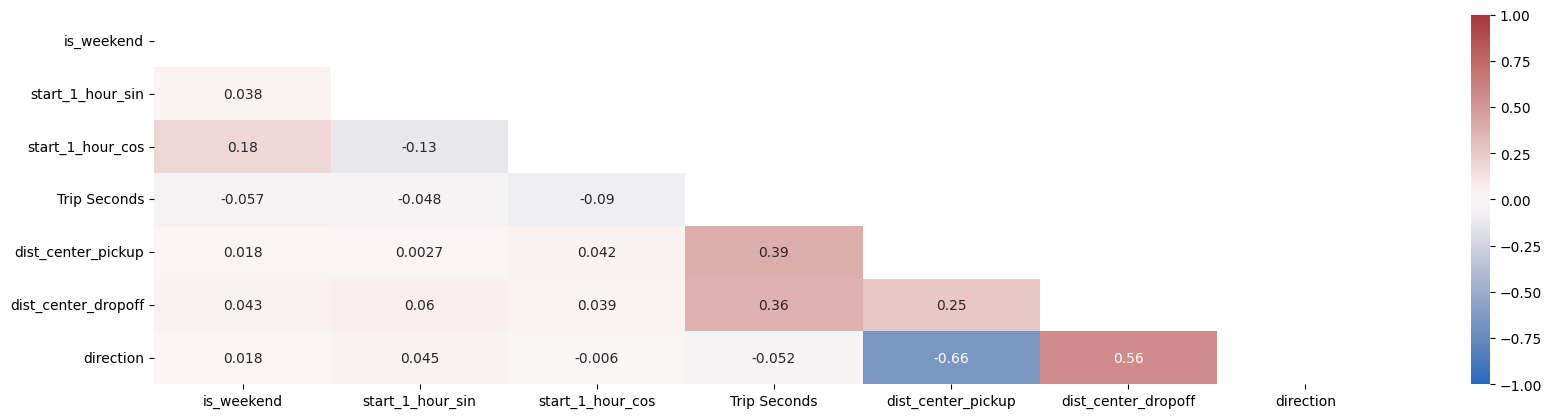

In [ ]:
plt_corr(df_trips_enc_clust_scaled)

A strong correlation between direction and dist_center_pickup and dist_center_dropoff is observable. This is because of the calculation of the feature depending on the two distance features.

Calculate the optimal number of clusters using a Grid Search

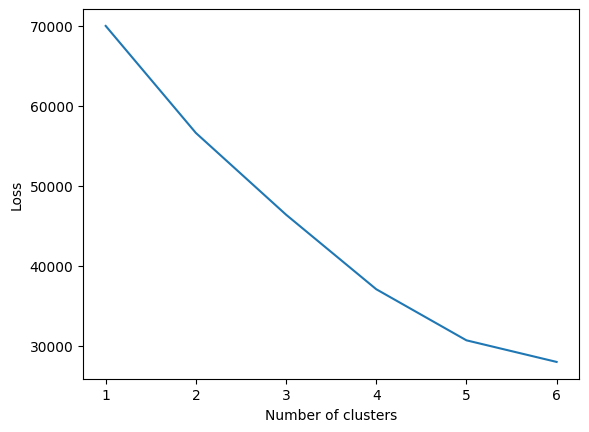

In [ ]:
gridSearch(df_trips_enc_clust_scaled, 6)

According to the elbow chart, the optimal number of clusters is 5.

### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [ ]:
num_cluster = 4

#### Gaussian Mixture Model

In [ ]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_trips_enc_clust_scaled, df_trips_clust)

In [ ]:
df_trips_clust

is_weekend  start_1_hour  Trip Seconds  dist_center_pickup  \
0              0           8.0         840.0                   6   
1              1          22.0        1108.0                   8   
2              0          23.0         600.0                   4   
3              1          11.0           0.0                   2   
4              0          22.0         360.0                   6   
...          ...           ...           ...                 ...   
9995           0           7.0         780.0                  25   
9996           1          18.0         249.0                   7   
9997           0          23.0         300.0                  24   
9998           0          12.0         480.0                  12   
9999           0          11.0         540.0                   8   

      dist_center_dropoff  direction  cluster_GaussianMixture  
0                       4         -2                        1  
1                      32         24                        2  
2                      12          8                        2  
3                       2          0                        1  
4                       4         -2                        2  
...                   ...        ...                      ...  
9995                    7        -18                        0  
9996                    0         -7                        2  
9997                   21         -3                        2  
9998                    3         -9                        1  
9999                   22         14                        0  

[10000 rows x 7 columns]

In [ ]:
feature_distribution(df_trips_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour            \
                              mean       std         mean       std   
cluster_GaussianMixture                                               
0                         0.323599  0.467929    12.367402  6.148703   
1                         0.191089  0.393228    11.793944  2.744329   
2                         0.372549  0.483541    15.589670  8.101955   

                        Trip Seconds              dist_center_pickup  \
                                mean          std               mean   
cluster_GaussianMixture                                                
0                        1319.604414  1011.988497          30.090662   
1                         434.067177   274.307298           3.734424   
2                         503.016978   331.810883           7.034433   

                                   dist_center_dropoff            direction  \
                               std                mean        std      mean   
cluster_GaussianMixture                                                       
0                        26.183007           26.710357  24.043693 -3.380306   
1                         3.553430            3.531848   3.444614 -0.202576   
2                         7.145380            8.952176   8.380174  1.917743   

                                   cluster_size first_is_weekend  \
                               std                                 
cluster_GaussianMixture                                            
0                        39.101657         2945                0   
1                         4.172553         2873                0   
2                         7.126118         4182                0   

                        first_start_1_hour first_Trip Seconds  \
                                                                
cluster_GaussianMixture                                         
0                                     13.0                0.0   
1                                      9.0                0.0   
2                                     19.0                0.0   

                        first_dist_center_pickup first_dist_center_dropoff  \
                                                                             
cluster_GaussianMixture                                                      
0                                             79                         0   
1                                              0                         0   
2                                              0                         0   

                        first_direction  
                                         
cluster_GaussianMixture                  
0                                     0  
1                                     0  
2                                     0

#### KMeans

In [ ]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_trips_enc_clust_scaled, df_trips_clust)

In [ ]:
df_trips_clust

is_weekend  start_1_hour  Trip Seconds  dist_center_pickup  \
0              0           8.0         840.0                   6   
1              1          22.0        1108.0                   8   
2              0          23.0         600.0                   4   
3              1          11.0           0.0                   2   
4              0          22.0         360.0                   6   
...          ...           ...           ...                 ...   
9995           0           7.0         780.0                  25   
9996           1          18.0         249.0                   7   
9997           0          23.0         300.0                  24   
9998           0          12.0         480.0                  12   
9999           0          11.0         540.0                   8   

      dist_center_dropoff  direction  cluster_GaussianMixture  cluster_KMeans  
0                       4         -2                        1               1  
1                      32         24                        2               1  
2                      12          8                        2               1  
3                       2          0                        1               1  
4                       4         -2                        2               1  
...                   ...        ...                      ...             ...  
9995                    7        -18                        0               1  
9996                    0         -7                        2               1  
9997                   21         -3                        2               1  
9998                    3         -9                        1               1  
9999                   22         14                        0               1  

[10000 rows x 8 columns]

In [ ]:
feature_distribution(df_trips_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour           Trip Seconds  \
                     mean       std         mean       std         mean   
cluster_KMeans                                                            
0                0.266043  0.442183    12.268717  5.811749  1773.223262   
1                0.316016  0.464946    13.564356  6.716593   535.025160   
2                0.221889  0.415829    14.805097  5.876438  1975.059970   

                            dist_center_pickup            dist_center_dropoff  \
                        std               mean        std                mean   
cluster_KMeans                                                                  
0               1123.284777          16.225936  20.922078           58.187166   
1                409.903472           8.349680   9.808216            8.858707   
2                967.230126          67.383808  17.533398           10.001499   

                           direction            cluster_size first_is_weekend  \
                      std       mean        std                                 
cluster_KMeans                                                                  
0               19.527683  41.961230  25.059444          748                0   
1                9.889744   0.509027   8.009907         8585                0   
2               12.513716 -57.382309  20.405775          667                0   

               first_start_1_hour first_Trip Seconds first_dist_center_pickup  \
                                                                                
cluster_KMeans                                                                  
0                            16.0             1020.0                        7   
1                            19.0                0.0                        0   
2                            17.0             1740.0                       79   

               first_dist_center_dropoff first_direction  
                                                          
cluster_KMeans                                            
0                                     79               0  
1                                      0               0  
2                                      0             -76

#### Evaluation

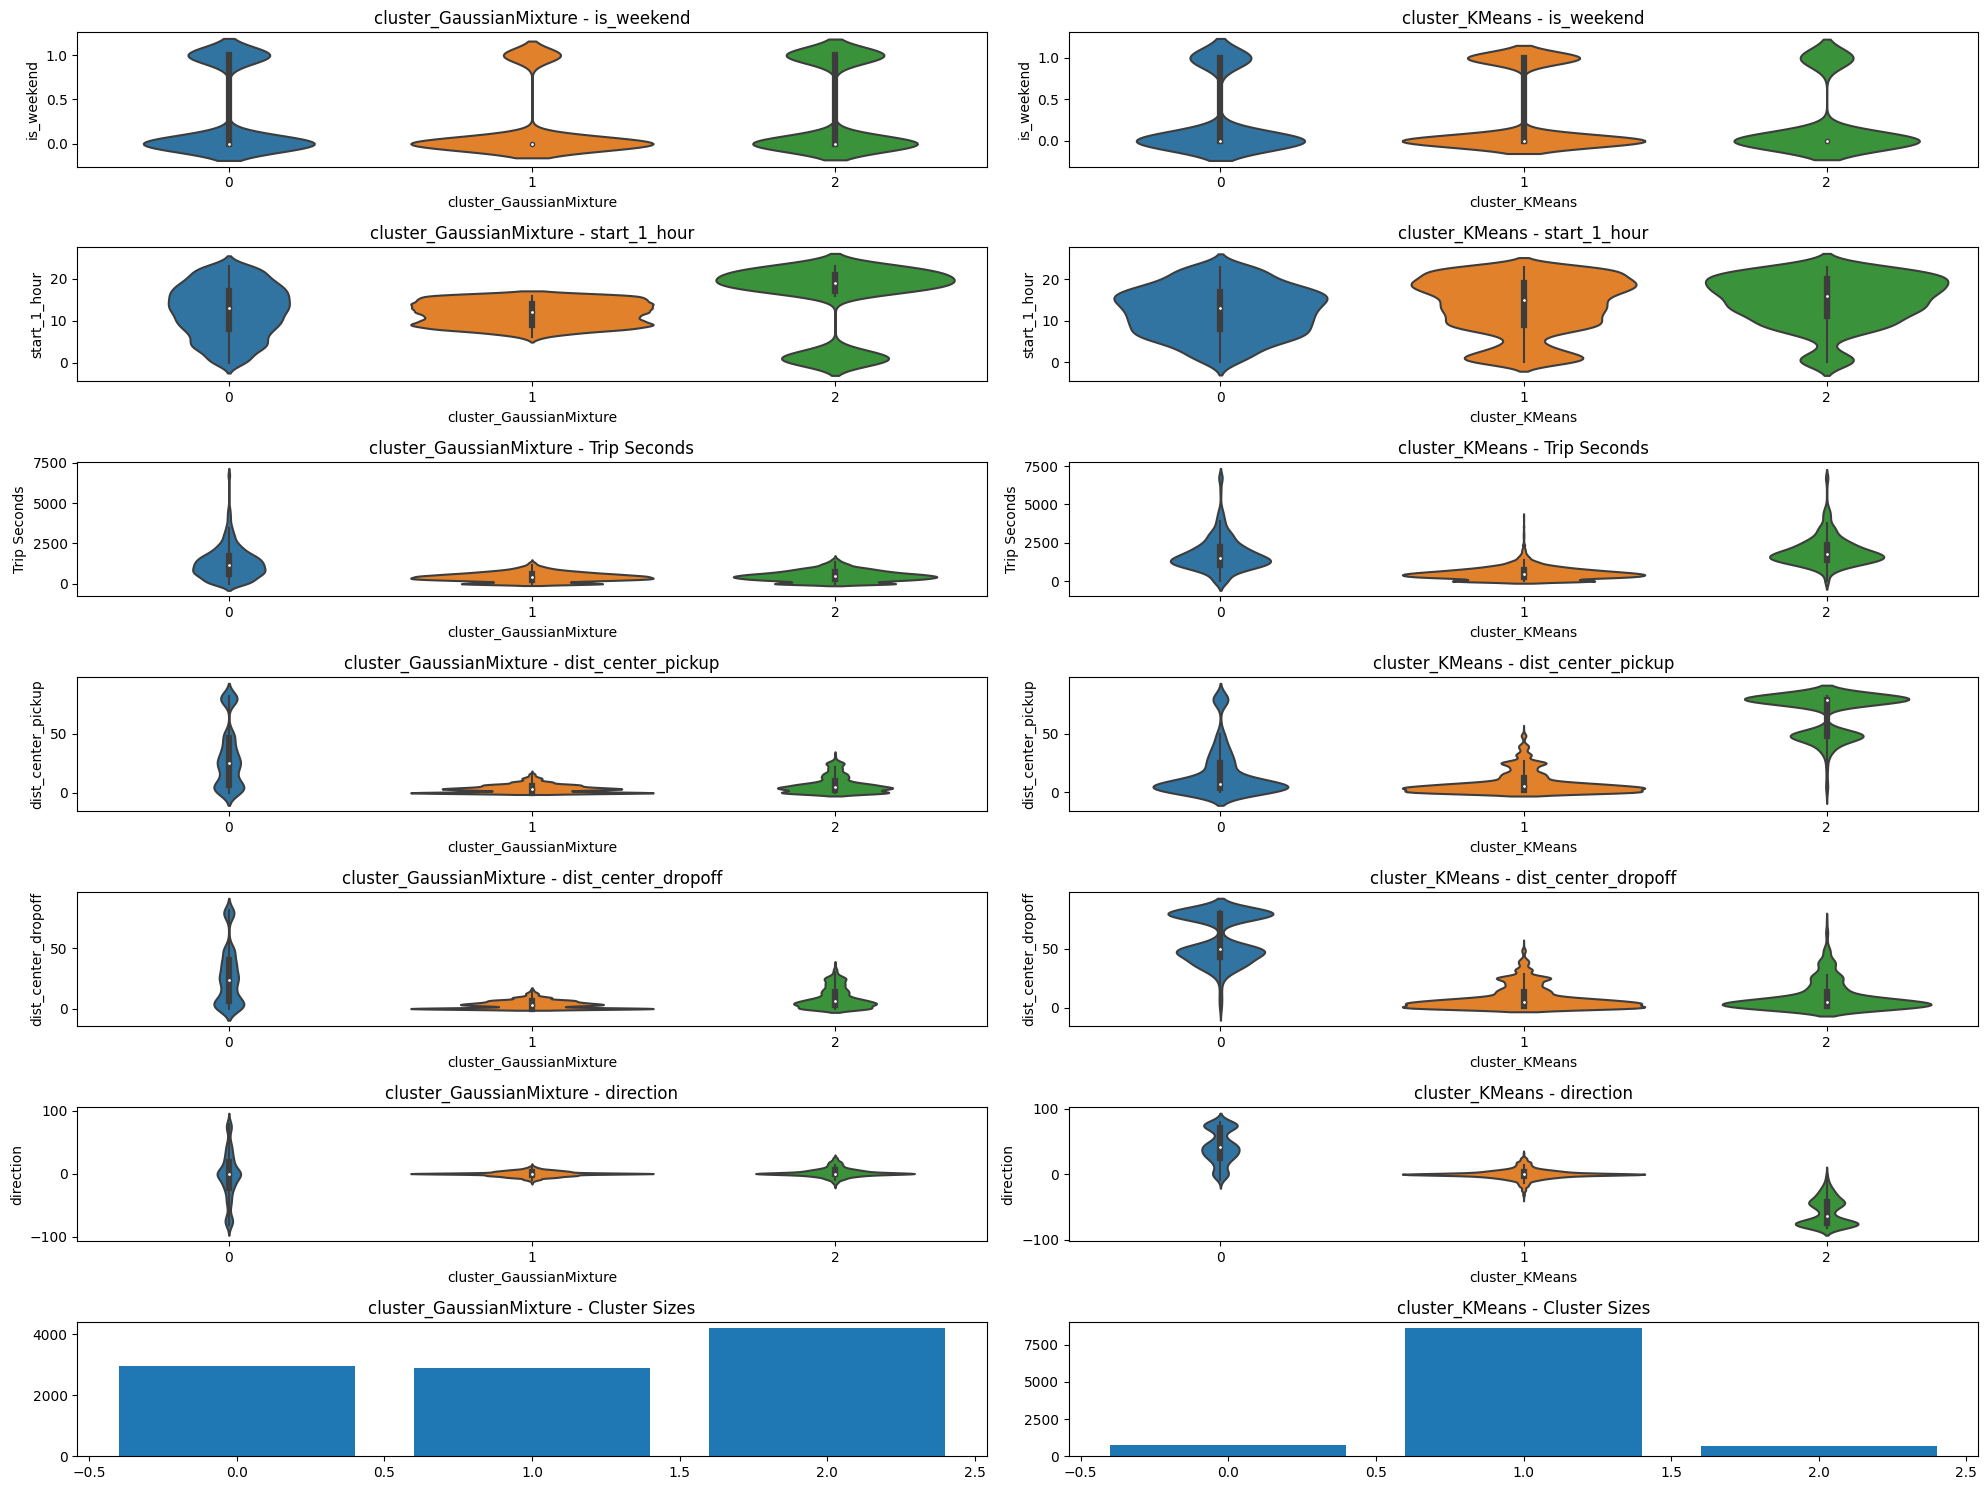

In [ ]:
plt_violins(df_trips_clust)

## Trip/Customer clustering

Clustering based on customer specific features.

In [ ]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0    2014-01-21 08:00:00          1.0              1           0.781831   
1    2014-02-01 22:00:00          2.0              5          -0.974928   
2    2014-11-14 23:00:00         11.0              4          -0.433884   
3    2014-03-16 11:00:00          3.0              6          -0.781831   
4    2014-03-21 22:00:00          3.0              4          -0.433884   
...                  ...          ...            ...                ...   
9995 2014-06-19 07:00:00          6.0              3           0.433884   
9996 2014-05-18 18:00:00          5.0              6          -0.781831   
9997 2014-05-16 23:00:00          5.0              4          -0.433884   
9998 2014-10-28 12:00:00         10.0              1           0.781831   
9999 2014-12-11 11:00:00         12.0              3           0.433884   

      start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0              0.623490           8.0      8.660254e-01     -5.000000e-01   
1             -0.222521          22.0     -5.000000e-01      8.660254e-01   
2             -0.900969          23.0     -2.588190e-01      9.659258e-01   
3              0.623490          11.0      2.588190e-01     -9.659258e-01   
4             -0.900969          22.0     -5.000000e-01      8.660254e-01   
...                 ...           ...               ...               ...   
9995          -0.900969           7.0      9.659258e-01     -2.588190e-01   
9996           0.623490          18.0     -1.000000e+00     -1.836970e-16   
9997          -0.900969          23.0     -2.588190e-01      9.659258e-01   
9998           0.623490          12.0      1.224647e-16     -1.000000e+00   
9999          -0.900969          11.0      2.588190e-01     -9.659258e-01   

      Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0            840.0        9.75  892664c1eabffff  892664c1e73ffff   
1           1108.0       15.25  892664ca913ffff  892664c80afffff   
2            600.0       10.65  892664c1e0fffff  892664c114fffff   
3              0.0        3.25  892664c1acfffff  892664c1acfffff   
4            360.0        7.55  892664c1e13ffff  892664c1e0fffff   
...            ...         ...              ...              ...   
9995         780.0       14.05  892664c1607ffff  892664c1ecfffff   
9996         249.0        8.05  892664cad77ffff  892664c1a8bffff   
9997         300.0        6.45  892664c1633ffff  892664c105bffff   
9998         480.0       10.65  892664c1b6fffff  892664c1ab3ffff   
9999         540.0       14.46  892664ca913ffff  892664c8cabffff   

      Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                   1.0                       0.0                   6   
1                   1.0                       0.0                   8   
2                   1.0                       0.0                   4   
3                   1.0                       0.0                   2   
4                   1.0                       0.0                   6   
...                 ...                       ...                 ...   
9995                1.0                       0.0                  25   
9996                0.0                       1.0                   7   
9997                1.0                       0.0                  24   
9998                0.0                       1.0                  12   
9999                0.0                       1.0                   8   

      dist_center_dropoff  direction  is_weekend  
0                       4         -2           0  
1                      32         24           1  
2                      12          8           0  
3                       2          0           1  
4                       4         -2           0  
...                   ...        ...         ...  
9995                    7        -18           0  
9996                    0         -7           1  
9997                   21     

In [ ]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [ ]:
# Clustering features
trips_customer_clust_feat     = ['is_weekend',  'start_1_hour', 'Trip Total', 'Payment Type_Credit Card']
# Encoded features
trips_customer_enc_clust_feat = ['is_weekend',  'start_1_hour_sin', 'Trip Total', 'Payment Type_Credit Card']

df_trips_customer_clust = df_trips[trips_customer_clust_feat]
df_trips_customer_enc_clust = df_trips[trips_customer_enc_clust_feat]

Scale encoded dataframe

In [ ]:
df_trips_customer_enc_clust_scaled = scale_df(df_trips_customer_enc_clust)

Plot correlation matrix to check for depended features

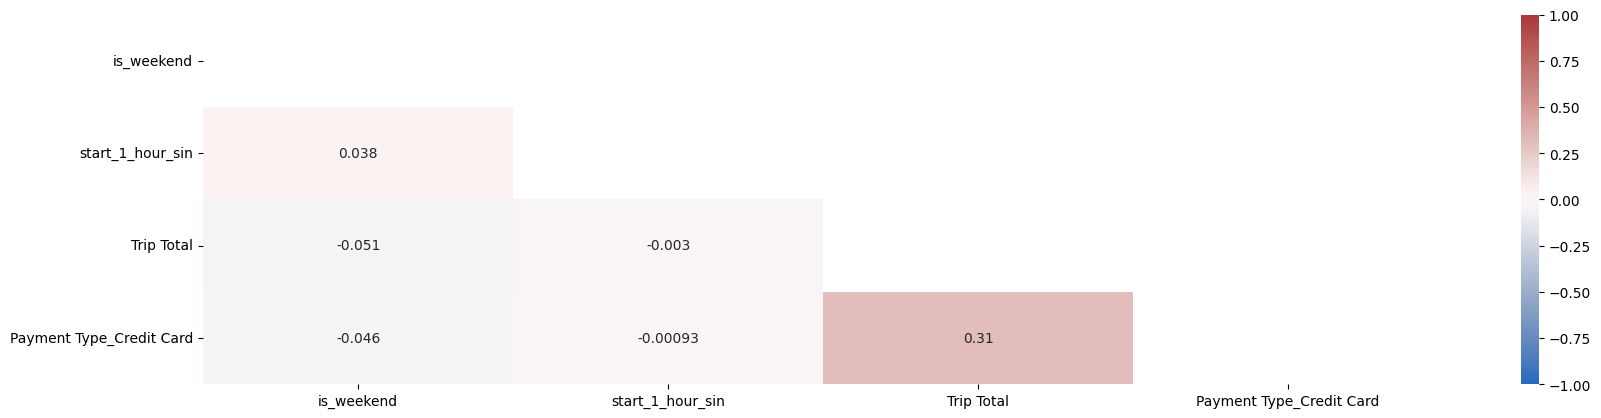

In [ ]:
plt_corr(df_trips_customer_enc_clust_scaled)

A strong correlation between direction and dist_center_pickup and dist_center_dropoff is observable. This is because of the calculation of the feature depending on the two distance features.

Calculate the optimal number of clusters using a Grid Search

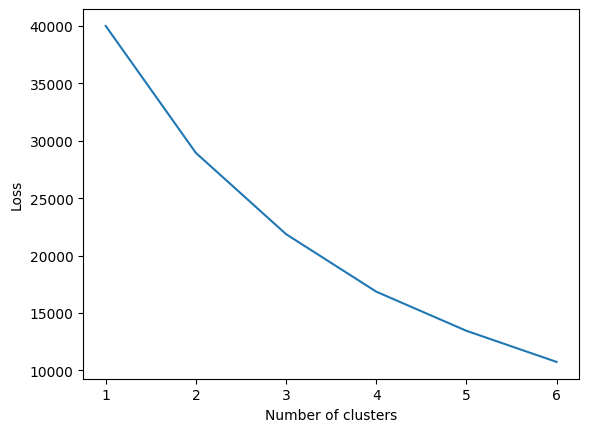

In [ ]:
gridSearch(df_trips_customer_enc_clust_scaled, 6)

According to the elbow chart, the optimal number of clusters is 2.

### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [ ]:
num_cluster = 2

#### Gaussian Mixture Model

In [ ]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_trips_customer_enc_clust_scaled, df_trips_customer_clust)

In [ ]:
df_trips_customer_clust

is_weekend  start_1_hour  Trip Total  Payment Type_Credit Card  \
0              0           8.0        9.75                       0.0   
1              1          22.0       15.25                       0.0   
2              0          23.0       10.65                       0.0   
3              1          11.0        3.25                       0.0   
4              0          22.0        7.55                       0.0   
...          ...           ...         ...                       ...   
9995           0           7.0       14.05                       0.0   
9996           1          18.0        8.05                       1.0   
9997           0          23.0        6.45                       0.0   
9998           0          12.0       10.65                       1.0   
9999           0          11.0       14.46                       1.0   

      cluster_GaussianMixture  
0                           1  
1                           1  
2                           1  
3                           1  
4                           1  
...                       ...  
9995                        1  
9996                        1  
9997                        1  
9998                        1  
9999                        1  

[10000 rows x 5 columns]

In [ ]:
feature_distribution(df_trips_customer_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour            \
                              mean       std         mean       std   
cluster_GaussianMixture                                               
0                         0.256144  0.436605    13.347826  6.453397   
1                         0.319381  0.466266    13.604515  6.659140   

                        Trip Total            Payment Type_Credit Card  \
                              mean        std                     mean   
cluster_GaussianMixture                                                  
0                        33.155397  14.685337                 0.547732   
1                         8.606556   3.107324                 0.311010   

                                  cluster_size first_is_weekend  \
                              std                                 
cluster_GaussianMixture                                           
0                        0.497834         2116                0   
1                        0.462936         7884                0   

                        first_start_1_hour first_Trip Total  \
                                                              
cluster_GaussianMixture                                       
0                                     17.0            18.05   
1                                     19.0             3.25   

                        first_Payment Type_Credit Card  
                                                        
cluster_GaussianMixture                                 
0                                                  1.0  
1                                                  0.0

#### KMeans

In [ ]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_trips_customer_enc_clust_scaled, df_trips_customer_clust)

In [ ]:
df_trips_customer_clust

is_weekend  start_1_hour  Trip Total  Payment Type_Credit Card  \
0              0           8.0        9.75                       0.0   
1              1          22.0       15.25                       0.0   
2              0          23.0       10.65                       0.0   
3              1          11.0        3.25                       0.0   
4              0          22.0        7.55                       0.0   
...          ...           ...         ...                       ...   
9995           0           7.0       14.05                       0.0   
9996           1          18.0        8.05                       1.0   
9997           0          23.0        6.45                       0.0   
9998           0          12.0       10.65                       1.0   
9999           0          11.0       14.46                       1.0   

      cluster_GaussianMixture  cluster_KMeans  
0                           1               1  
1                           1               1  
2                           1               1  
3                           1               1  
4                           1               1  
...                       ...             ...  
9995                        1               1  
9996                        1               0  
9997                        1               1  
9998                        1               0  
9999                        1               0  

[10000 rows x 6 columns]

In [ ]:
feature_distribution(df_trips_customer_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour           Trip Total  \
                     mean       std         mean       std       mean   
cluster_KMeans                                                          
0                0.276940  0.447548    13.588977  6.696232  19.450165   
1                0.322682  0.467539    13.527940  6.570957  10.558187   

                          Payment Type_Credit Card           cluster_size  \
                      std                     mean       std                
cluster_KMeans                                                              
0               16.094679                 0.990129  0.098876         3647   
1                8.033600                 0.000000  0.000000         6353   

               first_is_weekend first_start_1_hour first_Trip Total  \
                                                                      
cluster_KMeans                                                        
0                             0               19.0             8.05   
1                             0               18.0             3.25   

               first_Payment Type_Credit Card  
                                               
cluster_KMeans                                 
0                                         1.0  
1                                         0.0

#### Evaluation

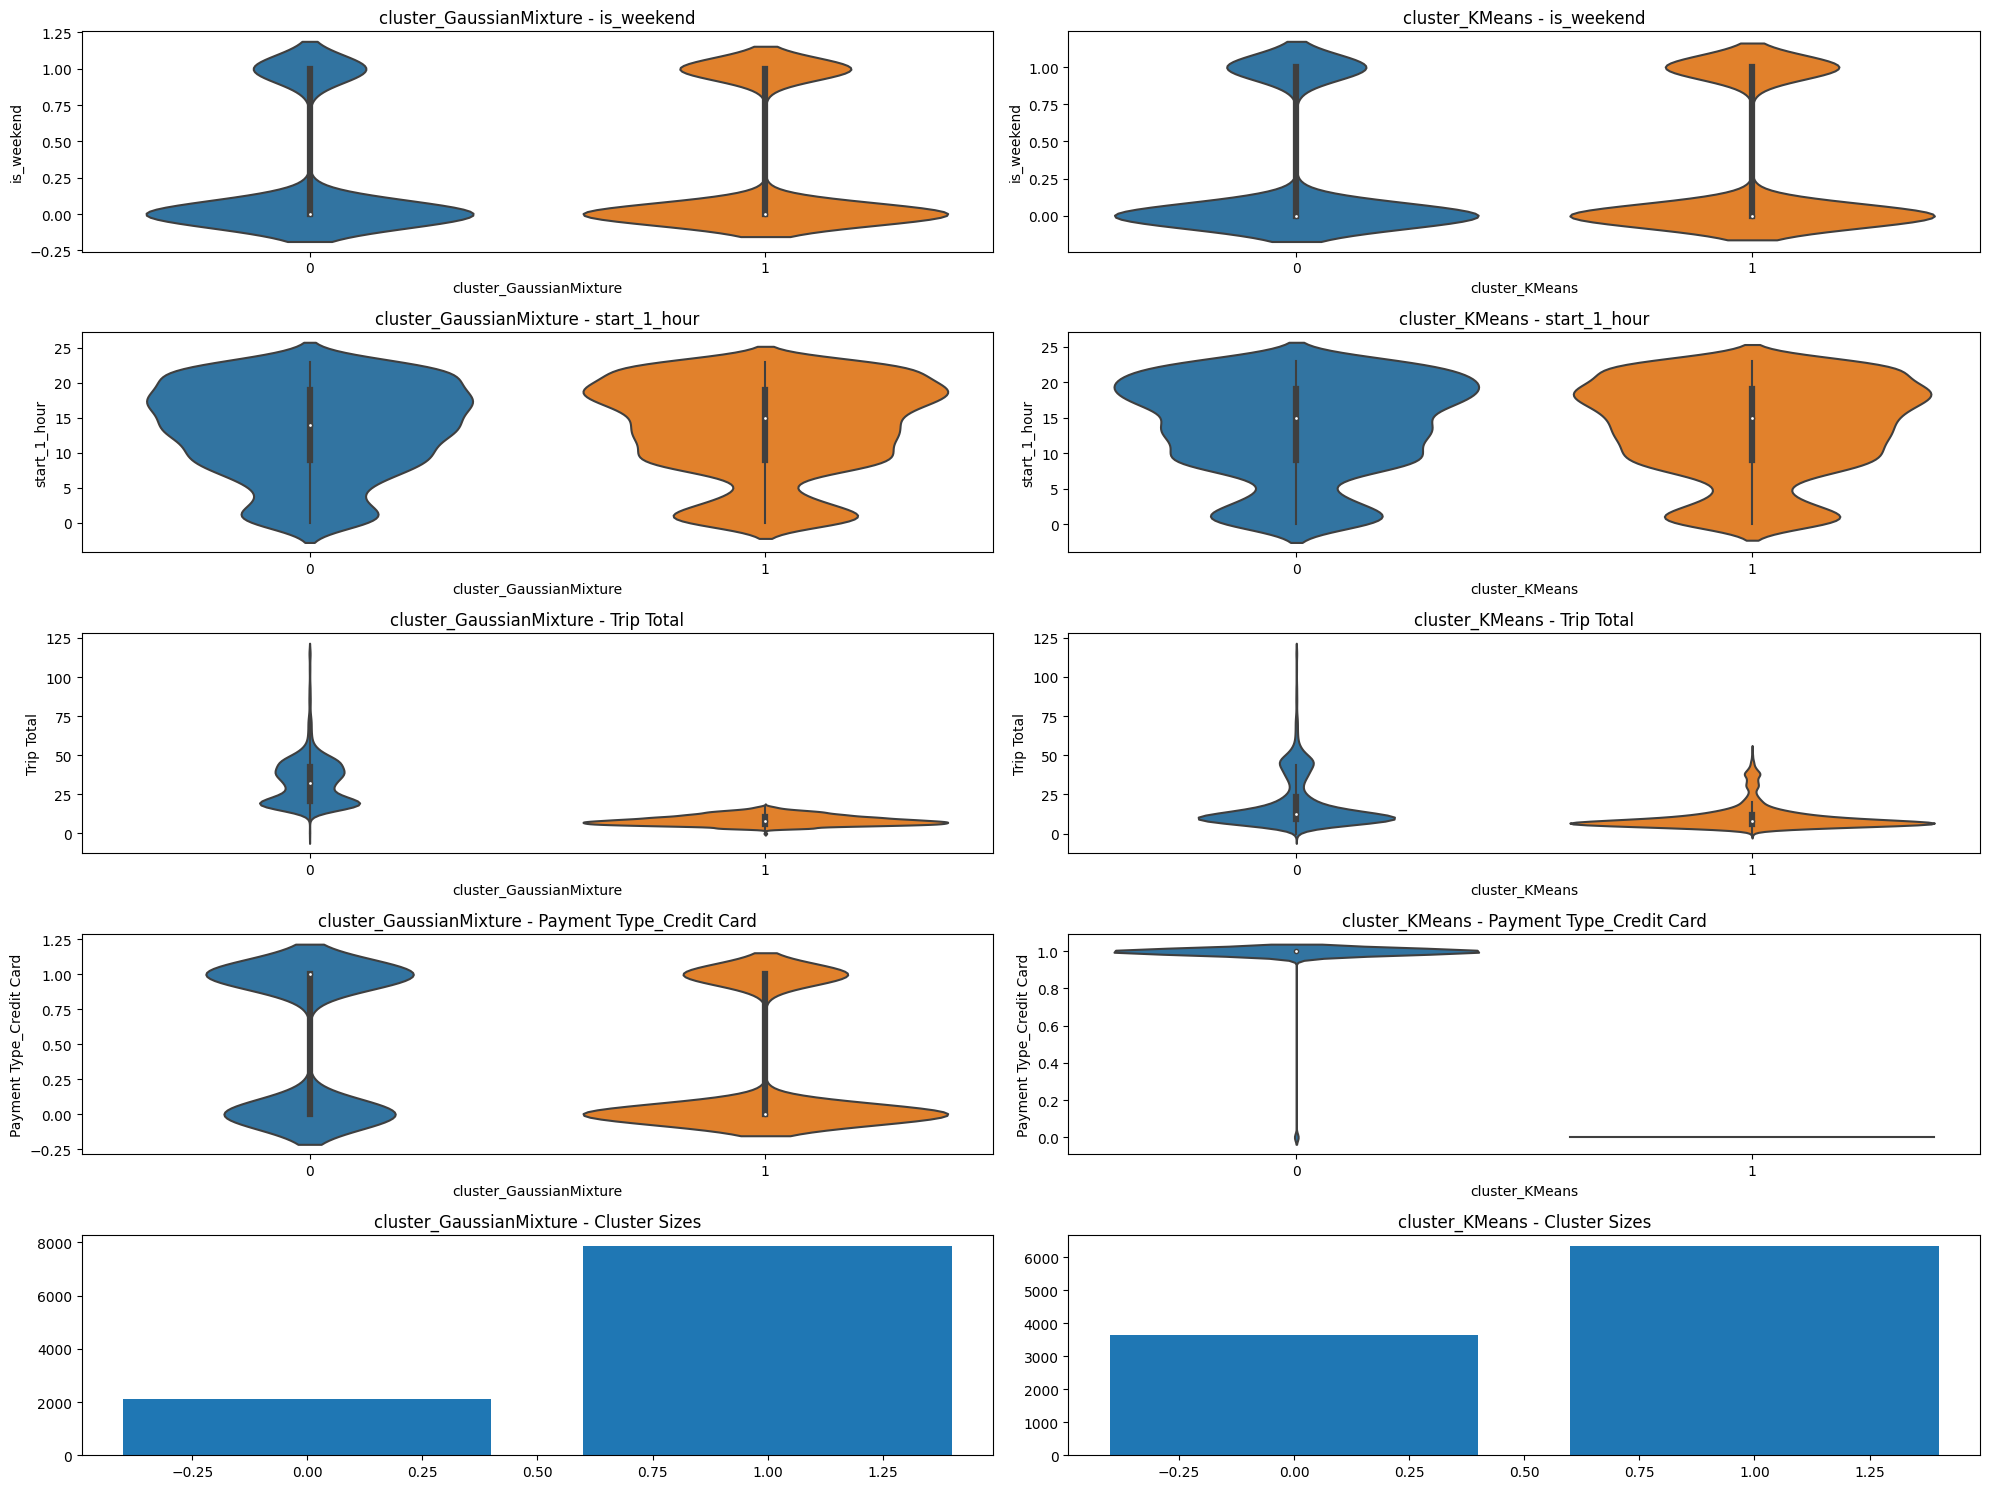

In [ ]:
plt_violins(df_trips_customer_clust)

# Weather-based clustering

## Weather clustering

Clustering based on same features as trip clustering enhanced by weather feature

In [ ]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0    2014-01-21 08:00:00          1.0              1           0.781831   
1    2014-02-01 22:00:00          2.0              5          -0.974928   
2    2014-11-14 23:00:00         11.0              4          -0.433884   
3    2014-03-16 11:00:00          3.0              6          -0.781831   
4    2014-03-21 22:00:00          3.0              4          -0.433884   
...                  ...          ...            ...                ...   
9995 2014-06-19 07:00:00          6.0              3           0.433884   
9996 2014-05-18 18:00:00          5.0              6          -0.781831   
9997 2014-05-16 23:00:00          5.0              4          -0.433884   
9998 2014-10-28 12:00:00         10.0              1           0.781831   
9999 2014-12-11 11:00:00         12.0              3           0.433884   

      start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0              0.623490           8.0      8.660254e-01     -5.000000e-01   
1             -0.222521          22.0     -5.000000e-01      8.660254e-01   
2             -0.900969          23.0     -2.588190e-01      9.659258e-01   
3              0.623490          11.0      2.588190e-01     -9.659258e-01   
4             -0.900969          22.0     -5.000000e-01      8.660254e-01   
...                 ...           ...               ...               ...   
9995          -0.900969           7.0      9.659258e-01     -2.588190e-01   
9996           0.623490          18.0     -1.000000e+00     -1.836970e-16   
9997          -0.900969          23.0     -2.588190e-01      9.659258e-01   
9998           0.623490          12.0      1.224647e-16     -1.000000e+00   
9999          -0.900969          11.0      2.588190e-01     -9.659258e-01   

      Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0            840.0        9.75  892664c1eabffff  892664c1e73ffff   
1           1108.0       15.25  892664ca913ffff  892664c80afffff   
2            600.0       10.65  892664c1e0fffff  892664c114fffff   
3              0.0        3.25  892664c1acfffff  892664c1acfffff   
4            360.0        7.55  892664c1e13ffff  892664c1e0fffff   
...            ...         ...              ...              ...   
9995         780.0       14.05  892664c1607ffff  892664c1ecfffff   
9996         249.0        8.05  892664cad77ffff  892664c1a8bffff   
9997         300.0        6.45  892664c1633ffff  892664c105bffff   
9998         480.0       10.65  892664c1b6fffff  892664c1ab3ffff   
9999         540.0       14.46  892664ca913ffff  892664c8cabffff   

      Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                   1.0                       0.0                   6   
1                   1.0                       0.0                   8   
2                   1.0                       0.0                   4   
3                   1.0                       0.0                   2   
4                   1.0                       0.0                   6   
...                 ...                       ...                 ...   
9995                1.0                       0.0                  25   
9996                0.0                       1.0                   7   
9997                1.0                       0.0                  24   
9998                0.0                       1.0                  12   
9999                0.0                       1.0                   8   

      dist_center_dropoff  direction  is_weekend  
0                       4         -2           0  
1                      32         24           1  
2                      12          8           0  
3                       2          0           1  
4                       4         -2           0  
...                   ...        ...         ...  
9995                    7        -18           0  
9996                    0         -7           1  
9997                   21     

In [ ]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [ ]:
# Clustering features
trips_clust_feat     = ['ts_start_1_hour', 'is_weekend',  'start_1_hour', 'Trip Seconds']
# Encoded features
trips_enc_clust_feat = ['ts_start_1_hour', 'is_weekend',  'start_1_hour_sin', 'start_1_hour_cos', 'Trip Seconds']

df_trips_clust = df_trips[trips_clust_feat]
df_trips_enc_clust = df_trips[trips_enc_clust_feat]

In [ ]:
df_weather

Temperature  Precip.  cloud
datetime                                        
2014-01-01 00:00:00        -10.0      0.0    3.0
2014-01-01 01:00:00         -8.9      0.0    3.0
2014-01-01 02:00:00         -8.3      0.0    3.0
2014-01-01 03:00:00         -7.8      0.0    3.0
2014-01-01 04:00:00         -7.2      0.0    3.0
...                          ...      ...    ...
2014-12-31 19:00:00         -7.2      0.0    0.0
2014-12-31 20:00:00         -7.2      0.0    0.0
2014-12-31 21:00:00         -6.7      0.0    0.0
2014-12-31 22:00:00         -6.7      0.0    0.0
2014-12-31 23:00:00         -6.7      0.0    0.0

[8760 rows x 3 columns]

Joining trips and weather data

In [ ]:
df_weather_clust = df_trips_clust.merge(df_weather, left_on='ts_start_1_hour', right_on='datetime', how='left')
df_weather_enc_clust = df_trips_enc_clust.merge(df_weather, left_on='ts_start_1_hour', right_on='datetime', how='left')

df_weather_clust.drop(columns=['ts_start_1_hour'], inplace=True)
df_weather_enc_clust.drop(columns=['ts_start_1_hour'], inplace=True)

In [ ]:
df_weather_clust

is_weekend  start_1_hour  Trip Seconds  Temperature  Precip.  cloud
0              0           8.0         840.0        -16.1      0.0    0.0
1              1          22.0        1108.0         -3.3      0.0    3.0
2              0          23.0         600.0         -3.3      0.0    2.0
3              1          11.0           0.0         -5.6      0.0    2.0
4              0          22.0         360.0          8.9      0.0    3.0
...          ...           ...           ...          ...      ...    ...
9995           0           7.0         780.0         17.2      0.0    0.0
9996           1          18.0         249.0         20.0      0.0    1.0
9997           0          23.0         300.0          6.7      0.0    3.0
9998           0          12.0         480.0         15.6      0.0    0.0
9999           0          11.0         540.0         -1.1      0.0    0.0

[10000 rows x 6 columns]

Scale encoded dataframe

In [ ]:
df_weather_enc_clust_scaled = scale_df(df_weather_enc_clust)

Plot correlation matrix to check for depended features

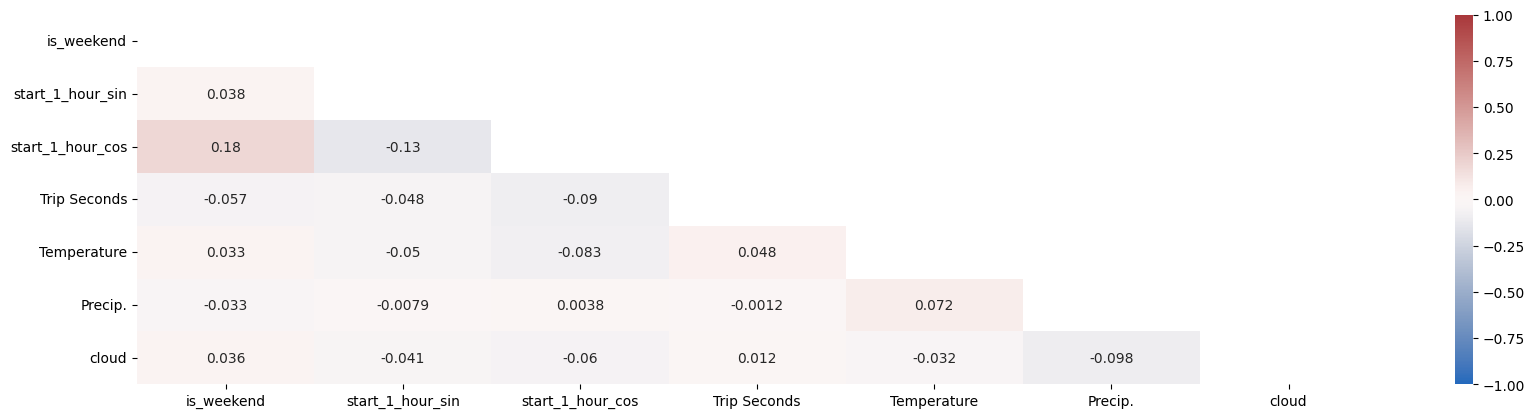

In [ ]:
plt_corr(df_weather_enc_clust_scaled)

A strong correlation between direction and dist_center_pickup and dist_center_dropoff is observable. This is because of the calculation of the feature depending on the two distance features.

Calculate the optimal number of clusters using a Grid Search

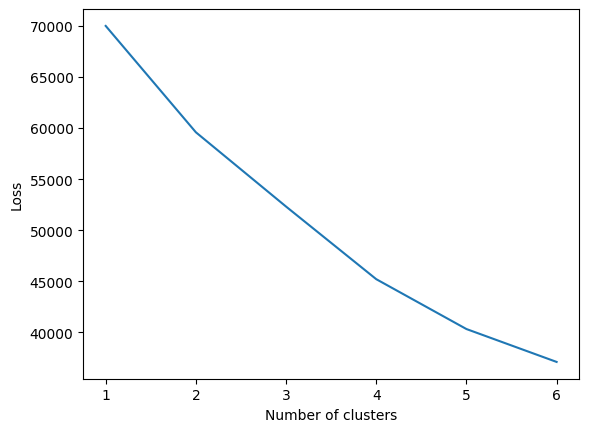

In [ ]:
gridSearch(df_weather_enc_clust_scaled, 6)

According to the elbow chart, the optimal number of clusters is 4.

### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [ ]:
num_cluster = 2

#### Gaussian Mixture Model

In [ ]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_weather_enc_clust_scaled, df_weather_clust)

In [ ]:
df_weather_clust

is_weekend  start_1_hour  Trip Seconds  Temperature  Precip.  cloud  \
0              0           8.0         840.0        -16.1      0.0    0.0   
1              1          22.0        1108.0         -3.3      0.0    3.0   
2              0          23.0         600.0         -3.3      0.0    2.0   
3              1          11.0           0.0         -5.6      0.0    2.0   
4              0          22.0         360.0          8.9      0.0    3.0   
...          ...           ...           ...          ...      ...    ...   
9995           0           7.0         780.0         17.2      0.0    0.0   
9996           1          18.0         249.0         20.0      0.0    1.0   
9997           0          23.0         300.0          6.7      0.0    3.0   
9998           0          12.0         480.0         15.6      0.0    0.0   
9999           0          11.0         540.0         -1.1      0.0    0.0   

      cluster_GaussianMixture  
0                           0  
1                           3  
2                           1  
3                           3  
4                           1  
...                       ...  
9995                        0  
9996                        3  
9997                        1  
9998                        0  
9999                        0  

[10000 rows x 7 columns]

In [ ]:
feature_distribution(df_weather_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour            \
                              mean       std         mean       std   
cluster_GaussianMixture                                               
0                         0.000000  0.000000     9.691218  1.849058   
1                         0.000000  0.000000    16.211646  6.077983   
2                         0.180488  0.385535    13.960976  6.802425   
3                         1.000000  0.000000    12.128680  7.686334   

                        Trip Seconds              Temperature             \
                                mean          std        mean        std   
cluster_GaussianMixture                                                    
0                         789.618036   859.416819   11.241218  12.880950   
1                         732.674474   708.082661   10.696627  12.279694   
2                         878.770732  1265.313668   16.894634   7.263238   
3                         653.159444   554.505063   11.807674  11.637411   

                         Precip.               cloud           cluster_size  \
                            mean       std      mean       std                
cluster_GaussianMixture                                                       
0                        0.00000  0.000000  1.524079  1.245165         2118   
1                        0.00000  0.000000  1.611517  1.231231         4654   
2                        0.21561  0.198401  0.643902  1.190248          205   
3                        0.00000  0.000000  1.668541  1.165901         3023   

                        first_is_weekend first_start_1_hour  \
                                                              
cluster_GaussianMixture                                       
0                                      0                9.0   
1                                      0               19.0   
2                                      0               19.0   
3                                      1                1.0   

                        first_Trip Seconds first_Temperature first_Precip.  \
                                                                             
cluster_GaussianMixture                                                      
0                                      0.0              23.3           0.0   
1                                      0.0              19.4           0.0   
2                                      0.0              22.8           0.1   
3                                      0.0              22.8           0.0   

                        first_cloud  
                                     
cluster_GaussianMixture              
0                               0.0  
1                               3.0  
2                               0.0  
3                               3.0

#### KMeans

In [ ]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_weather_enc_clust_scaled, df_weather_clust)

In [ ]:
df_weather_clust

is_weekend  start_1_hour  Trip Seconds  Temperature  Precip.  cloud  \
0              0           8.0         840.0        -16.1      0.0    0.0   
1              1          22.0        1108.0         -3.3      0.0    3.0   
2              0          23.0         600.0         -3.3      0.0    2.0   
3              1          11.0           0.0         -5.6      0.0    2.0   
4              0          22.0         360.0          8.9      0.0    3.0   
...          ...           ...           ...          ...      ...    ...   
9995           0           7.0         780.0         17.2      0.0    0.0   
9996           1          18.0         249.0         20.0      0.0    1.0   
9997           0          23.0         300.0          6.7      0.0    3.0   
9998           0          12.0         480.0         15.6      0.0    0.0   
9999           0          11.0         540.0         -1.1      0.0    0.0   

      cluster_GaussianMixture  cluster_KMeans  
0                           0               0  
1                           3               1  
2                           1               2  
3                           3               1  
4                           1               2  
...                       ...             ...  
9995                        0               0  
9996                        3               1  
9997                        1               2  
9998                        0               0  
9999                        0               0  

[10000 rows x 8 columns]

In [ ]:
feature_distribution(df_weather_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour           Trip Seconds  \
                     mean       std         mean       std         mean   
cluster_KMeans                                                            
0                0.000000  0.000000    10.162023  2.691700   752.907121   
1                1.000000  0.000000    12.170652  7.695339   661.906977   
2                0.000000  0.000000    17.067703  6.043893   749.008776   
3                0.134615  0.344642    14.192308  5.911234   776.480769   

                           Temperature              Precip.            \
                       std        mean        std      mean       std   
cluster_KMeans                                                          
0               798.306788   11.206983  12.748485  0.002167  0.017563   
1               597.026779   11.850704  11.608503  0.000950  0.010969   
2               741.178221   10.749649  12.167549  0.002382  0.018654   
3               828.145116   21.548077   2.584455  0.490385  0.215352   

                   cloud           cluster_size first_is_weekend  \
                    mean       std                                 
cluster_KMeans                                                     
0               1.552460  1.234783         2907                0   
1               1.659679  1.169933         3053                1   
2               1.580491  1.247336         3988                0   
3               0.403846  0.913077           52                0   

               first_start_1_hour first_Trip Seconds first_Temperature  \
                                                                         
cluster_KMeans                                                           
0                             9.0                0.0              23.3   
1                             1.0                0.0              22.8   
2                            19.0                0.0              19.4   
3                            19.0                0.0              22.8   

               first_Precip. first_cloud  
                                          
cluster_KMeans                            
0                        0.0         0.0  
1                        0.0         3.0  
2                        0.0         3.0  
3                        0.3         0.0

#### Evaluation

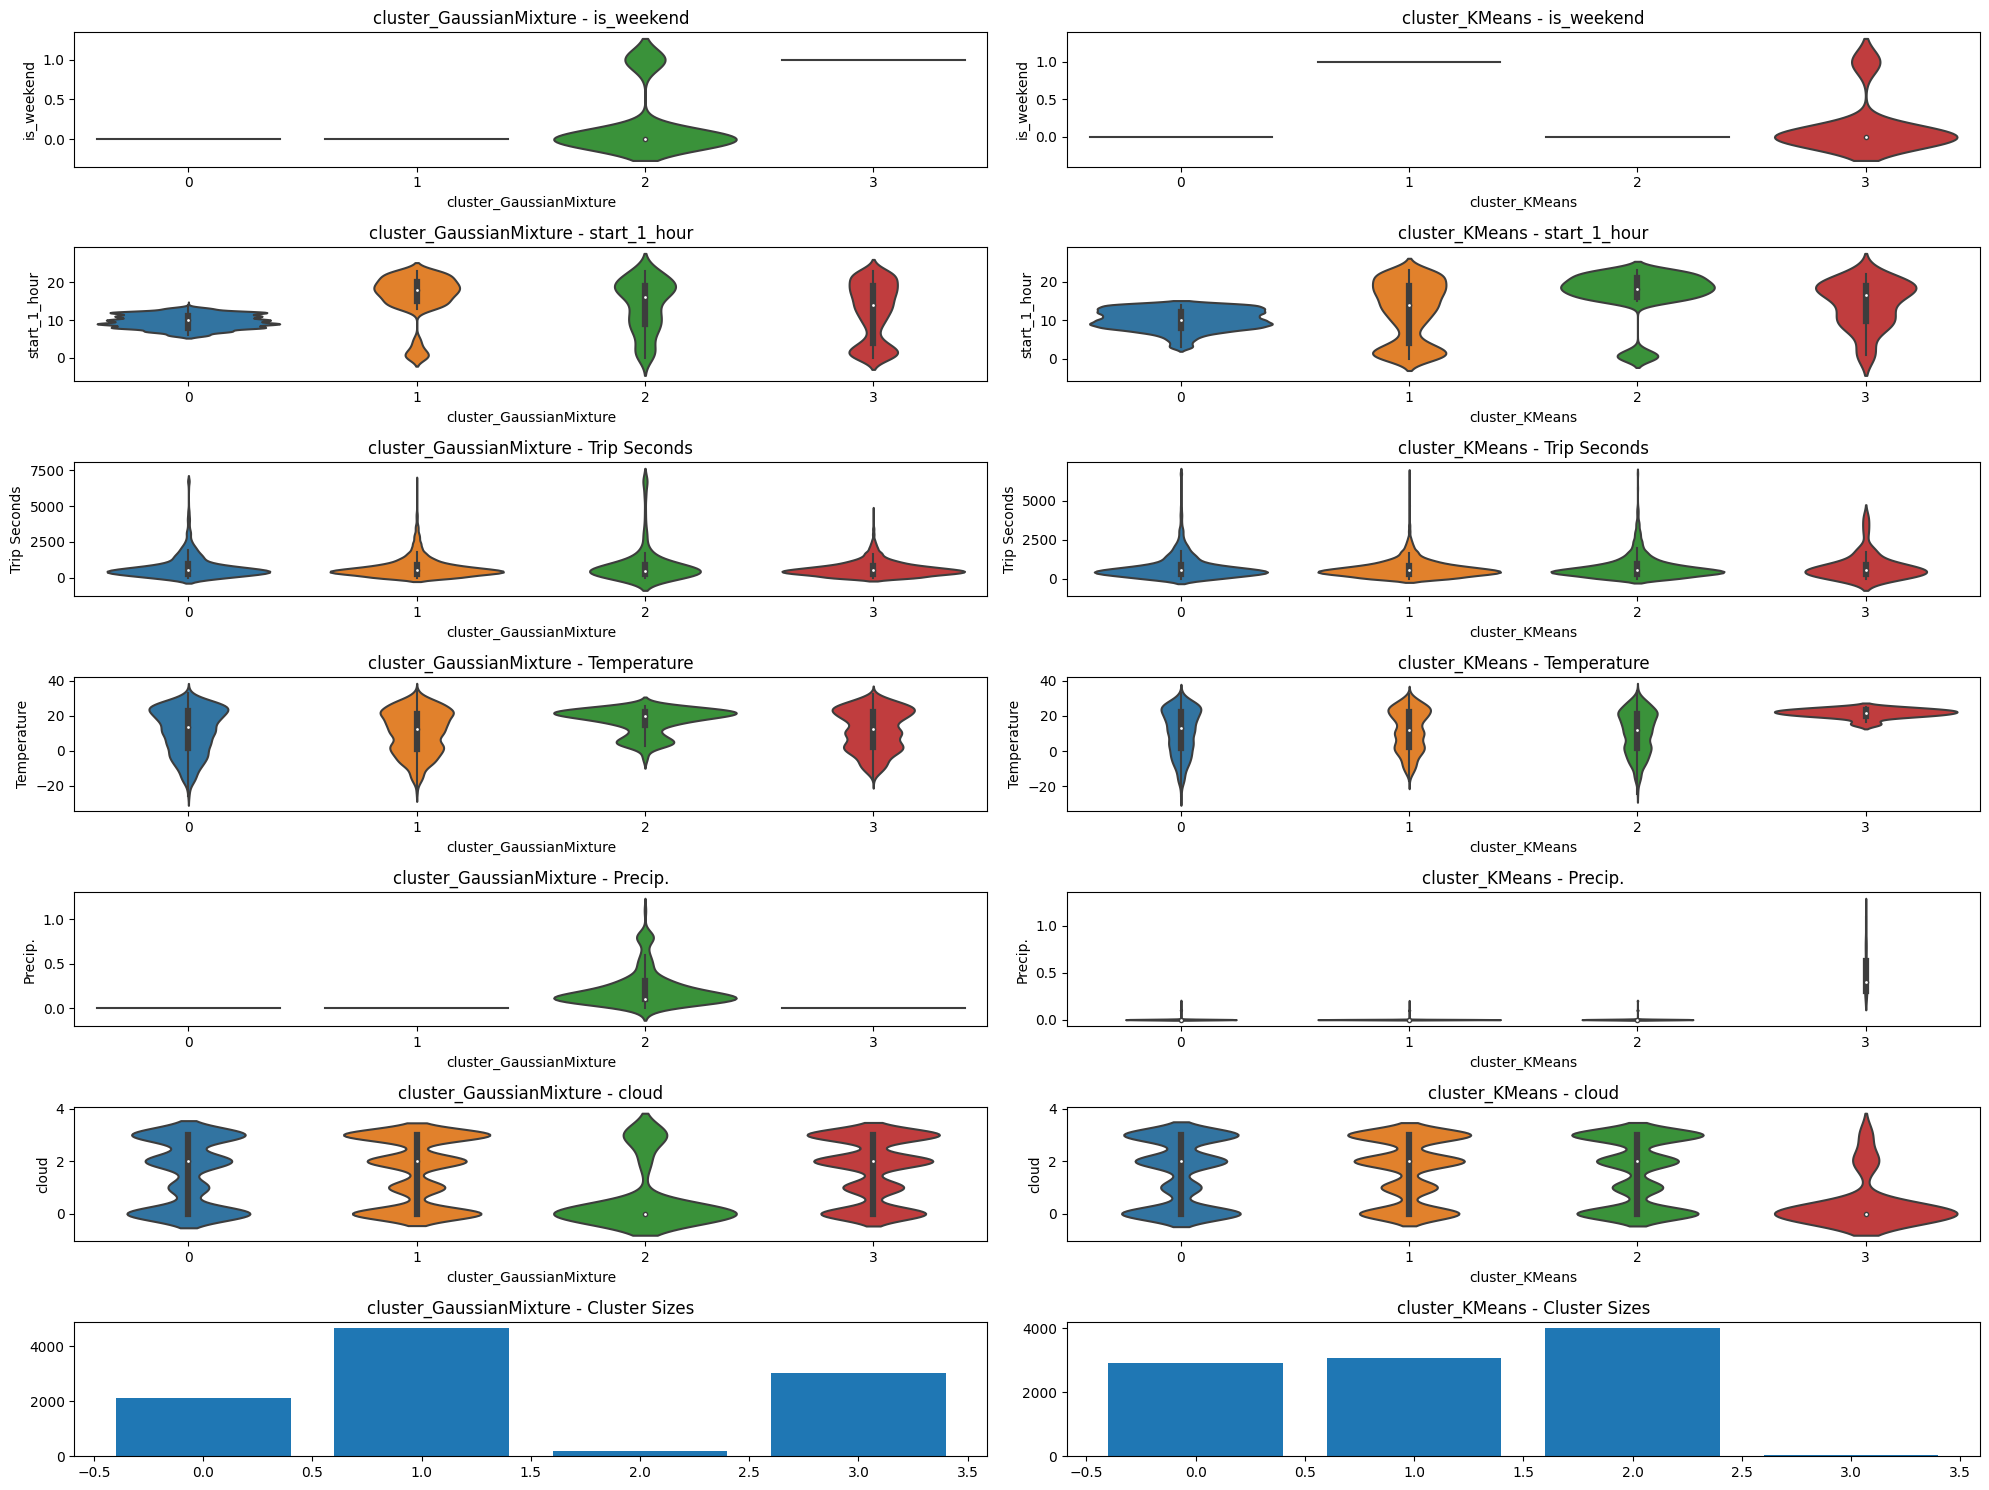

In [ ]:
plt_violins(df_weather_clust)

# Hexagon-based clustering

## Hexagon demand clustering

Clustering based on same features as trip clustering enhanced by weather feature

In [ ]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0    2014-01-21 08:00:00          1.0              1           0.781831   
1    2014-02-01 22:00:00          2.0              5          -0.974928   
2    2014-11-14 23:00:00         11.0              4          -0.433884   
3    2014-03-16 11:00:00          3.0              6          -0.781831   
4    2014-03-21 22:00:00          3.0              4          -0.433884   
...                  ...          ...            ...                ...   
9995 2014-06-19 07:00:00          6.0              3           0.433884   
9996 2014-05-18 18:00:00          5.0              6          -0.781831   
9997 2014-05-16 23:00:00          5.0              4          -0.433884   
9998 2014-10-28 12:00:00         10.0              1           0.781831   
9999 2014-12-11 11:00:00         12.0              3           0.433884   

      start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0              0.623490           8.0      8.660254e-01     -5.000000e-01   
1             -0.222521          22.0     -5.000000e-01      8.660254e-01   
2             -0.900969          23.0     -2.588190e-01      9.659258e-01   
3              0.623490          11.0      2.588190e-01     -9.659258e-01   
4             -0.900969          22.0     -5.000000e-01      8.660254e-01   
...                 ...           ...               ...               ...   
9995          -0.900969           7.0      9.659258e-01     -2.588190e-01   
9996           0.623490          18.0     -1.000000e+00     -1.836970e-16   
9997          -0.900969          23.0     -2.588190e-01      9.659258e-01   
9998           0.623490          12.0      1.224647e-16     -1.000000e+00   
9999          -0.900969          11.0      2.588190e-01     -9.659258e-01   

      Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0            840.0        9.75  892664c1eabffff  892664c1e73ffff   
1           1108.0       15.25  892664ca913ffff  892664c80afffff   
2            600.0       10.65  892664c1e0fffff  892664c114fffff   
3              0.0        3.25  892664c1acfffff  892664c1acfffff   
4            360.0        7.55  892664c1e13ffff  892664c1e0fffff   
...            ...         ...              ...              ...   
9995         780.0       14.05  892664c1607ffff  892664c1ecfffff   
9996         249.0        8.05  892664cad77ffff  892664c1a8bffff   
9997         300.0        6.45  892664c1633ffff  892664c105bffff   
9998         480.0       10.65  892664c1b6fffff  892664c1ab3ffff   
9999         540.0       14.46  892664ca913ffff  892664c8cabffff   

      Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                   1.0                       0.0                   6   
1                   1.0                       0.0                   8   
2                   1.0                       0.0                   4   
3                   1.0                       0.0                   2   
4                   1.0                       0.0                   6   
...                 ...                       ...                 ...   
9995                1.0                       0.0                  25   
9996                0.0                       1.0                   7   
9997                1.0                       0.0                  24   
9998                0.0                       1.0                  12   
9999                0.0                       1.0                   8   

      dist_center_dropoff  direction  is_weekend  
0                       4         -2           0  
1                      32         24           1  
2                      12          8           0  
3                       2          0           1  
4                       4         -2           0  
...                   ...        ...         ...  
9995                    7        -18           0  
9996                    0         -7           1  
9997                   21     

In [ ]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [ ]:
# Aggregate trips based on start_hour and hexagon ID
df_hex_pickup_clust = df_trips.groupby(by=['start_1_hour', f'pickup_hex_{HEX_RES}']).count()['ts_start_1_hour']

# unstack to retrieve demand in each hour as feature for each hexagon and fill resulting nan values with demand of zero
df_hex_pickup_clust = df_hex_pickup_clust.unstack(0)
df_hex_pickup_clust = df_hex_pickup_clust.fillna(0)

# rename columns
df_hex_pickup_clust.columns = df_hex_pickup_clust.columns.map(str)

df_hex_pickup_clust

start_1_hour      0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0   8.0   9.0  ...  \
pickup_hex_9                                                          ...   
89266419493ffff   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...   
892664520afffff   1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   4.0   3.0  ...   
89266452147ffff   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...   
89266452183ffff   3.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0   3.0   9.0  ...   
892664c1007ffff   1.0  0.0  2.0  0.0  0.0  0.0  2.0  1.0   0.0   1.0  ...   
...               ...  ...  ...  ...  ...  ...  ...  ...   ...   ...  ...   
892664d9bcbffff   2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   1.0  ...   
89275934333ffff   3.0  5.0  2.0  0.0  0.0  1.0  3.0  1.0   4.0   3.0  ...   
89275934cdbffff   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...   
89275934ed3ffff  15.0  5.0  0.0  1.0  0.0  0.0  4.0  7.0  13.0  11.0  ...   
892759369bbffff   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...   

start_1_hour     14.0  15.0  16.0  17.0  18.0  19.0  20.0  21.0  22.0  23.0  
pickup_hex_9                                                                 
89266419493ffff   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  
892664520afffff   1.0   2.0   4.0   1.0   0.0   0.0   0.0   1.0   3.0   3.0  
89266452147ffff   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
89266452183ffff   4.0   6.0   6.0   6.0   4.0   8.0   8.0  15.0  13.0   2.0  
892664c1007ffff   1.0   0.0   0.0   0.0   3.0   1.0   5.0   1.0   2.0   1.0  
...               ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
892664d9bcbffff   1.0   0.0   1.0   1.0   0.0   0.0   1.0   1.0   0.0   0.0  
89275934333ffff   4.0   6.0   7.0   5.0   4.0   5.0   3.0   6.0   2.0   2.0  
89275934cdbffff   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  
89275934ed3ffff  20.0  24.0  15.0  25.0  23.0  25.0  28.0  15.0  21.0  19.0  
892759369bbffff   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  

[217 rows x 24 columns]

Scale encoded dataframe

In [ ]:
df_hex_pickup_clust_scaled = scale_df(df_hex_pickup_clust)

Calculate the optimal number of clusters using a Grid Search

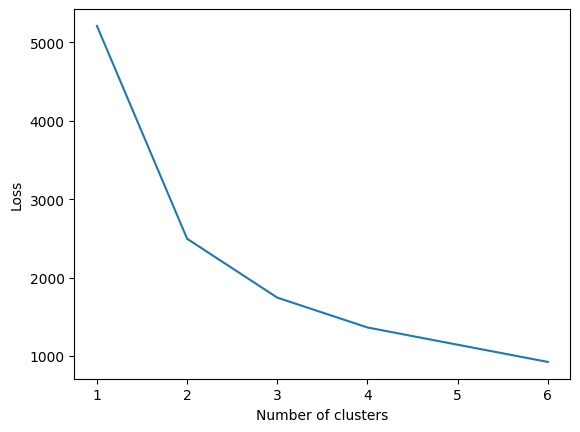

In [ ]:
gridSearch(df_hex_pickup_clust_scaled, 6)

According to the elbow chart, the optimal number of clusters is 2.

### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [ ]:
num_cluster = 2

#### Gaussian Mixture Model

In [ ]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_hex_pickup_clust_scaled, df_hex_pickup_clust)

In [ ]:
df_weather_clust

is_weekend  start_1_hour  Trip Seconds  Temperature  Precip.  cloud  \
0              0           8.0         840.0        -16.1      0.0    0.0   
1              1          22.0        1108.0         -3.3      0.0    3.0   
2              0          23.0         600.0         -3.3      0.0    2.0   
3              1          11.0           0.0         -5.6      0.0    2.0   
4              0          22.0         360.0          8.9      0.0    3.0   
...          ...           ...           ...          ...      ...    ...   
9995           0           7.0         780.0         17.2      0.0    0.0   
9996           1          18.0         249.0         20.0      0.0    1.0   
9997           0          23.0         300.0          6.7      0.0    3.0   
9998           0          12.0         480.0         15.6      0.0    0.0   
9999           0          11.0         540.0         -1.1      0.0    0.0   

      cluster_GaussianMixture  cluster_KMeans  
0                           0               0  
1                           3               1  
2                           1               2  
3                           3               1  
4                           1               2  
...                       ...             ...  
9995                        0               0  
9996                        3               1  
9997                        1               2  
9998                        0               0  
9999                        0               0  

[10000 rows x 8 columns]

In [ ]:
feature_distribution(df_hex_pickup_clust, f'cluster_{model.__class__.__name__}')

start_1_hour                   0.0                  1.0                 2.0  \
                              mean       std       mean       std      mean   
cluster_GaussianMixture                                                       
0                         1.081731  1.833150   1.038462  1.950712  0.774038   
1                        12.555556  7.108289  10.222222  8.393119  8.444444   

start_1_hour                            3.0                 4.0            \
                              std      mean       std      mean       std   
cluster_GaussianMixture                                                     
0                        1.507437  0.533654  1.162548  0.389423  1.242284   
1                        7.213028  5.000000  4.898979  4.000000  5.172040   

start_1_hour             ... first_14.0 first_15.0 first_16.0 first_17.0  \
                         ...                                               
cluster_GaussianMixture  ...                                               
0                        ...        0.0        0.0        0.0        0.0   
1                        ...       17.0       14.0       12.0        8.0   

start_1_hour            first_18.0 first_19.0 first_20.0 first_21.0  \
                                                                      
cluster_GaussianMixture                                               
0                              0.0        0.0        0.0        0.0   
1                              7.0       14.0       15.0       10.0   

start_1_hour            first_22.0 first_23.0  
                                               
cluster_GaussianMixture                        
0                              0.0        0.0  
1                             13.0       10.0  

[2 rows x 73 columns]

#### KMeans

In [ ]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_hex_pickup_clust_scaled, df_hex_pickup_clust)

In [ ]:
df_hex_pickup_clust

start_1_hour      0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0   8.0   9.0  ...  \
pickup_hex_9                                                          ...   
89266419493ffff   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...   
892664520afffff   1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   4.0   3.0  ...   
89266452147ffff   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...   
89266452183ffff   3.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0   3.0   9.0  ...   
892664c1007ffff   1.0  0.0  2.0  0.0  0.0  0.0  2.0  1.0   0.0   1.0  ...   
...               ...  ...  ...  ...  ...  ...  ...  ...   ...   ...  ...   
892664d9bcbffff   2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   1.0  ...   
89275934333ffff   3.0  5.0  2.0  0.0  0.0  1.0  3.0  1.0   4.0   3.0  ...   
89275934cdbffff   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...   
89275934ed3ffff  15.0  5.0  0.0  1.0  0.0  0.0  4.0  7.0  13.0  11.0  ...   
892759369bbffff   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...   

start_1_hour     16.0  17.0  18.0  19.0  20.0  21.0  22.0  23.0  \
pickup_hex_9                                                      
89266419493ffff   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
892664520afffff   4.0   1.0   0.0   0.0   0.0   1.0   3.0   3.0   
89266452147ffff   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
89266452183ffff   6.0   6.0   4.0   8.0   8.0  15.0  13.0   2.0   
892664c1007ffff   0.0   0.0   3.0   1.0   5.0   1.0   2.0   1.0   
...               ...   ...   ...   ...   ...   ...   ...   ...   
892664d9bcbffff   1.0   1.0   0.0   0.0   1.0   1.0   0.0   0.0   
89275934333ffff   7.0   5.0   4.0   5.0   3.0   6.0   2.0   2.0   
89275934cdbffff   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
89275934ed3ffff  15.0  25.0  23.0  25.0  28.0  15.0  21.0  19.0   
892759369bbffff   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   

start_1_hour     cluster_GaussianMixture  cluster_KMeans  
pickup_hex_9                                              
89266419493ffff                        0               0  
892664520afffff                        0               0  
89266452147ffff                        0               0  
89266452183ffff                        0               0  
892664c1007ffff                        0               0  
...                                  ...             ...  
892664d9bcbffff                        0               0  
89275934333ffff                        0               0  
89275934cdbffff                        0               0  
89275934ed3ffff                        1               1  
892759369bbffff                        0               0  

[217 rows x 26 columns]

In [ ]:
feature_distribution(df_hex_pickup_clust, f'cluster_{model.__class__.__name__}')

start_1_hour          0.0                 1.0                 2.0            \
                     mean       std      mean       std      mean       std   
cluster_KMeans                                                                
0                0.926108  1.544539  0.901478  1.706176  0.650246  1.202653   
1               10.714286  6.194645  8.928571  7.054342  7.500000  6.123724   

start_1_hour         3.0                 4.0            ... first_14.0  \
                    mean       std      mean       std  ...              
cluster_KMeans                                          ...              
0               0.463054  0.996213  0.261084  0.693544  ...        0.0   
1               4.428571  4.273609  4.571429  4.847113  ...       17.0   

start_1_hour   first_15.0 first_16.0 first_17.0 first_18.0 first_19.0  \
                                                                        
cluster_KMeans                                                          
0                     0.0        0.0        0.0        0.0        0.0   
1                     9.0        7.0       10.0        7.0       14.0   

start_1_hour   first_20.0 first_21.0 first_22.0 first_23.0  
                                                            
cluster_KMeans                                              
0                     0.0        0.0        0.0        0.0  
1                    15.0        9.0       10.0        8.0  

[2 rows x 73 columns]

#### Evaluation

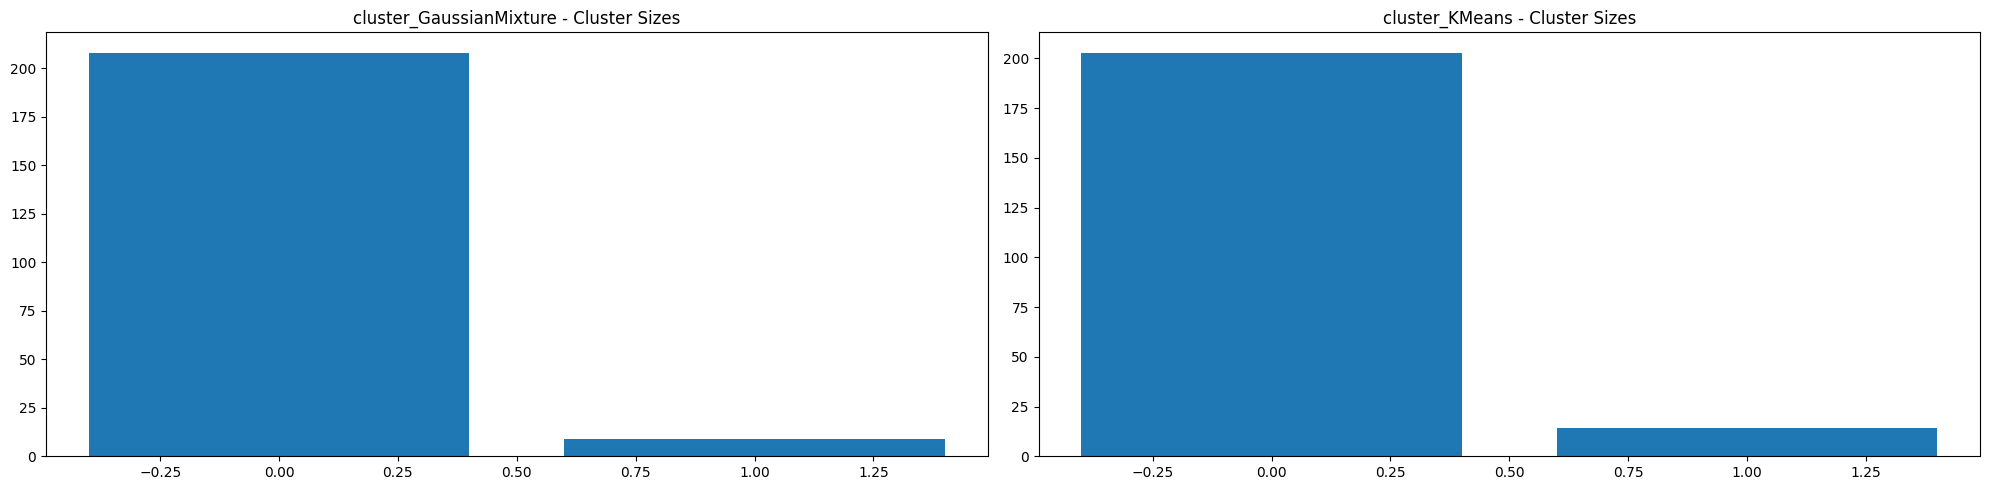

In [ ]:
plt_cluster_size(df_hex_pickup_clust)

['cluster_GaussianMixture', 'cluster_KMeans']
0 0 cluster_GaussianMixture
1 0 cluster_KMeans
0 1 cluster_GaussianMixture
1 1 cluster_KMeans


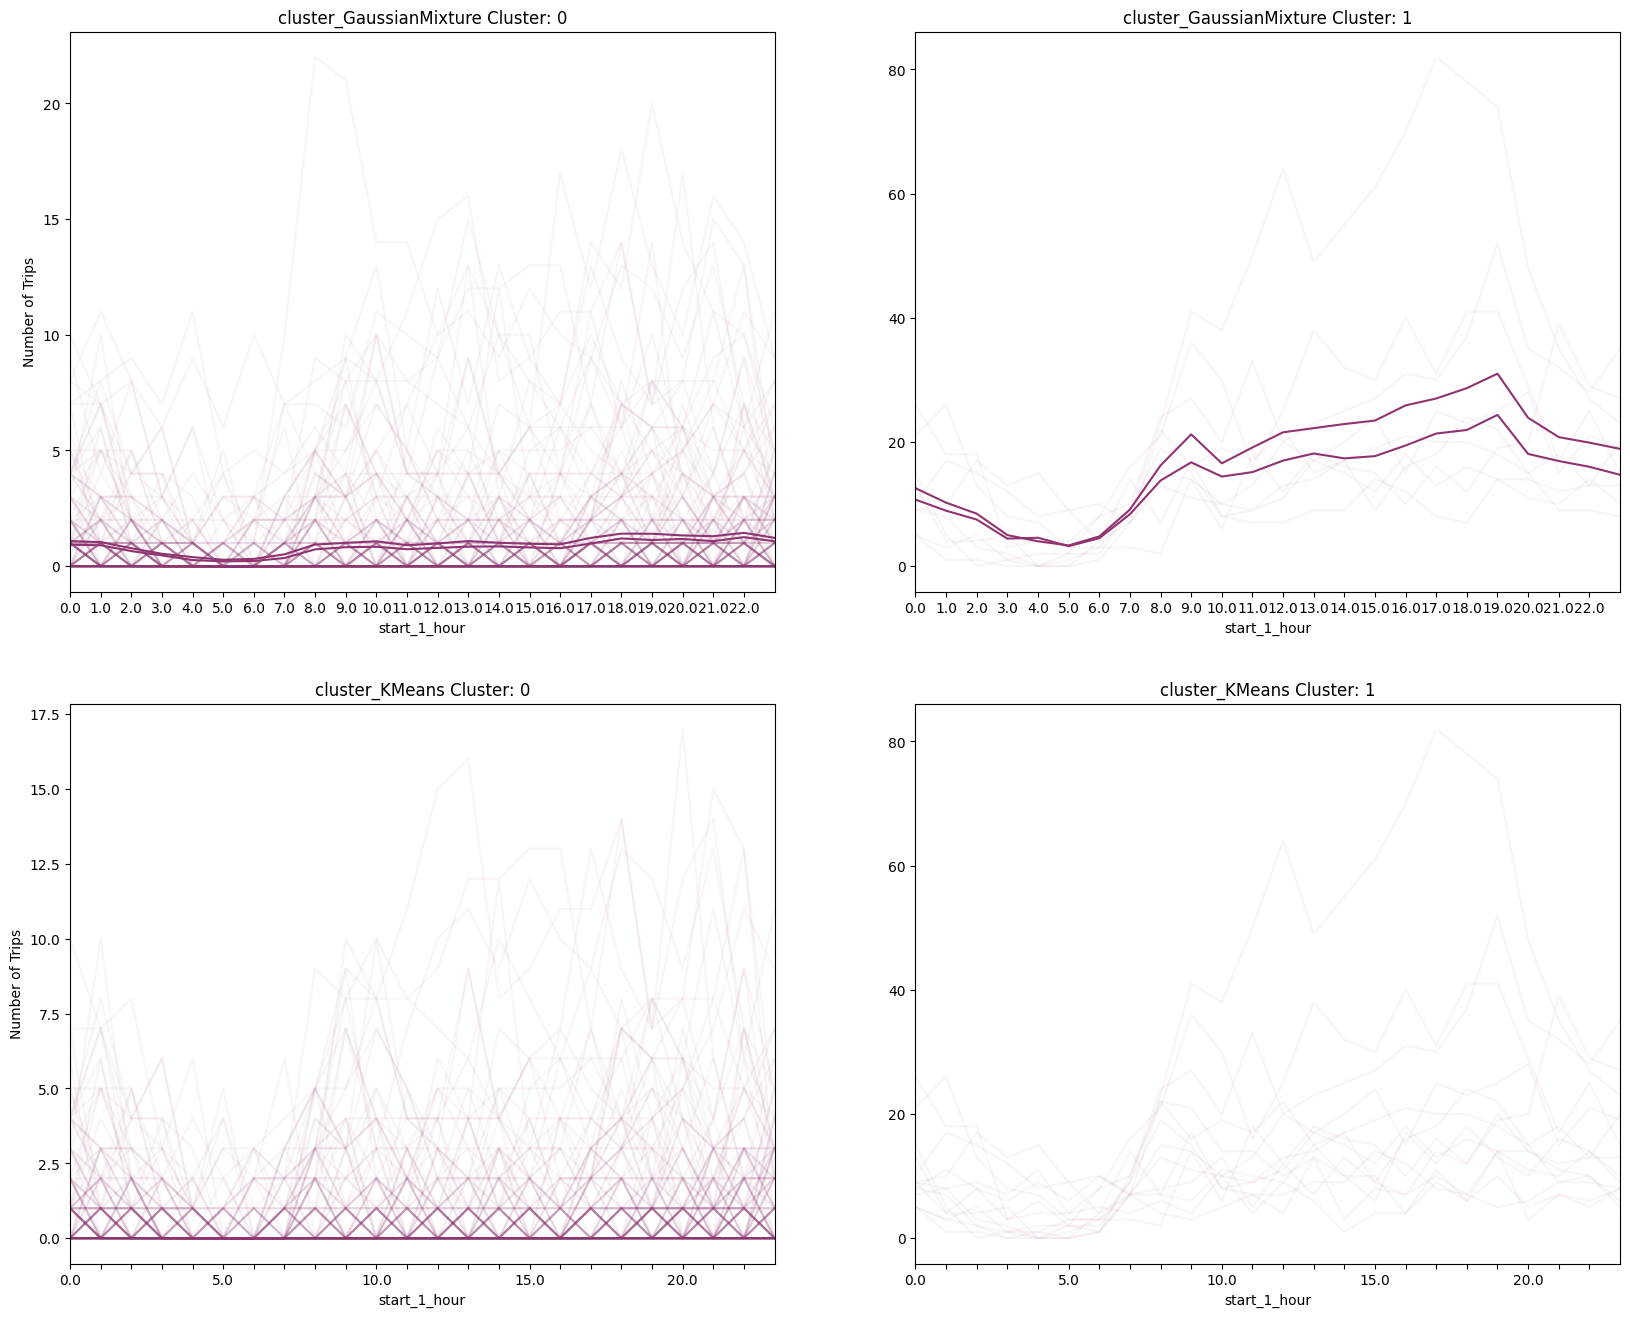

In [ ]:
plt_temporal_patterns(df_hex_pickup_clust, num_cluster)

In [ ]:
hex_to_map(df_hex_pickup_clust)

## Hexagon demand clustering separated by weekend

Clustering based on same features as the hexagon clustering but additionally separated by is_weekend

In [ ]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0    2014-01-21 08:00:00          1.0              1           0.781831   
1    2014-02-01 22:00:00          2.0              5          -0.974928   
2    2014-11-14 23:00:00         11.0              4          -0.433884   
3    2014-03-16 11:00:00          3.0              6          -0.781831   
4    2014-03-21 22:00:00          3.0              4          -0.433884   
...                  ...          ...            ...                ...   
9995 2014-06-19 07:00:00          6.0              3           0.433884   
9996 2014-05-18 18:00:00          5.0              6          -0.781831   
9997 2014-05-16 23:00:00          5.0              4          -0.433884   
9998 2014-10-28 12:00:00         10.0              1           0.781831   
9999 2014-12-11 11:00:00         12.0              3           0.433884   

      start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0              0.623490           8.0      8.660254e-01     -5.000000e-01   
1             -0.222521          22.0     -5.000000e-01      8.660254e-01   
2             -0.900969          23.0     -2.588190e-01      9.659258e-01   
3              0.623490          11.0      2.588190e-01     -9.659258e-01   
4             -0.900969          22.0     -5.000000e-01      8.660254e-01   
...                 ...           ...               ...               ...   
9995          -0.900969           7.0      9.659258e-01     -2.588190e-01   
9996           0.623490          18.0     -1.000000e+00     -1.836970e-16   
9997          -0.900969          23.0     -2.588190e-01      9.659258e-01   
9998           0.623490          12.0      1.224647e-16     -1.000000e+00   
9999          -0.900969          11.0      2.588190e-01     -9.659258e-01   

      Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0            840.0        9.75  892664c1eabffff  892664c1e73ffff   
1           1108.0       15.25  892664ca913ffff  892664c80afffff   
2            600.0       10.65  892664c1e0fffff  892664c114fffff   
3              0.0        3.25  892664c1acfffff  892664c1acfffff   
4            360.0        7.55  892664c1e13ffff  892664c1e0fffff   
...            ...         ...              ...              ...   
9995         780.0       14.05  892664c1607ffff  892664c1ecfffff   
9996         249.0        8.05  892664cad77ffff  892664c1a8bffff   
9997         300.0        6.45  892664c1633ffff  892664c105bffff   
9998         480.0       10.65  892664c1b6fffff  892664c1ab3ffff   
9999         540.0       14.46  892664ca913ffff  892664c8cabffff   

      Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                   1.0                       0.0                   6   
1                   1.0                       0.0                   8   
2                   1.0                       0.0                   4   
3                   1.0                       0.0                   2   
4                   1.0                       0.0                   6   
...                 ...                       ...                 ...   
9995                1.0                       0.0                  25   
9996                0.0                       1.0                   7   
9997                1.0                       0.0                  24   
9998                0.0                       1.0                  12   
9999                0.0                       1.0                   8   

      dist_center_dropoff  direction  is_weekend  
0                       4         -2           0  
1                      32         24           1  
2                      12          8           0  
3                       2          0           1  
4                       4         -2           0  
...                   ...        ...         ...  
9995                    7        -18           0  
9996                    0         -7           1  
9997                   21     

In [ ]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [ ]:
# separation

df_trips_wd = df_trips[df_trips.is_weekend == 0]
df_trips_we = df_trips[df_trips.is_weekend == 1]

In [ ]:
# Aggregate trips based on start_hour and hexagon ID
df_hex_pickup_clust_wd = df_trips_wd.groupby(by=['start_1_hour', f'pickup_hex_{HEX_RES}']).count()['ts_start_1_hour']

# unstack to retrieve demand in each hour as feature for each hexagon and fill resulting nan values with demand of zero
df_hex_pickup_clust_wd = df_hex_pickup_clust_wd.unstack(0)
df_hex_pickup_clust_wd = df_hex_pickup_clust_wd.fillna(0)

# rename columns
df_hex_pickup_clust_wd.columns = df_hex_pickup_clust_wd.columns.map(str)

df_hex_pickup_clust_wd

start_1_hour      0.0   1.0  2.0  3.0  4.0  5.0  6.0   7.0   8.0   9.0  ...  \
pickup_hex_9                                                            ...   
89266419493ffff   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0  ...   
892664520afffff   1.0   0.0  0.0  0.0  1.0  0.0  0.0   0.0   3.0   2.0  ...   
89266452147ffff   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0  ...   
89266452183ffff   3.0   1.0  0.0  0.0  0.0  0.0  0.0   2.0   3.0   6.0  ...   
892664c1007ffff   1.0   0.0  0.0  0.0  0.0  0.0  2.0   1.0   0.0   1.0  ...   
...               ...   ...  ...  ...  ...  ...  ...   ...   ...   ...  ...   
892664d9bcbffff   2.0   0.0  0.0  0.0  0.0  0.0  0.0   1.0   0.0   1.0  ...   
89275934333ffff   3.0   7.0  3.0  0.0  0.0  1.0  3.0   1.0   4.0   3.0  ...   
89275934ed3ffff  14.0   3.0  0.0  1.0  0.0  0.0  4.0   7.0  13.0  11.0  ...   
892759369bbffff   1.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0  ...   
None             18.0  13.0  7.0  2.0  2.0  3.0  5.0  10.0  21.0  32.0  ...   

start_1_hour     14.0  15.0  16.0  17.0  18.0  19.0  20.0  21.0  22.0  23.0  
pickup_hex_9                                                                 
89266419493ffff   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  
892664520afffff   0.0   0.0   3.0   1.0   0.0   4.0   0.0   3.0   3.0   3.0  
89266452147ffff   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
89266452183ffff   4.0   5.0   4.0   5.0   3.0   6.0   6.0  10.0   8.0   1.0  
892664c1007ffff   0.0   0.0   0.0   0.0   2.0   1.0   2.0   0.0   0.0   0.0  
...               ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
892664d9bcbffff   1.0   0.0   1.0   1.0   0.0   0.0   1.0   1.0   0.0   0.0  
89275934333ffff   3.0   7.0   5.0   8.0   7.0   5.0   7.0  12.0   0.0   6.0  
89275934ed3ffff  14.0  23.0  13.0  16.0  23.0  17.0  23.0  14.0  20.0  14.0  
892759369bbffff   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
None             29.0  17.0  20.0  31.0  27.0  36.0  30.0  33.0  24.0  24.0  

[193 rows x 24 columns]

In [ ]:
# Aggregate trips based on start_hour and hexagon ID
df_hex_pickup_clust_we = df_trips_we.groupby(by=['start_1_hour', f'pickup_hex_{HEX_RES}']).count()['ts_start_1_hour']

# unstack to retrieve demand in each hour as feature for each hexagon and fill resulting nan values with demand of zero
df_hex_pickup_clust_we = df_hex_pickup_clust_we.unstack(0)
df_hex_pickup_clust_we = df_hex_pickup_clust_we.fillna(0)

# rename columns
df_hex_pickup_clust_we.columns = df_hex_pickup_clust_we.columns.map(str)

df_hex_pickup_clust_we

start_1_hour      0.0   1.0   2.0   3.0   4.0  5.0  6.0  7.0  8.0  9.0  ...  \
pickup_hex_9                                                            ...   
892664520afffff   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  1.0  1.0  ...   
89266452183ffff   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  3.0  ...   
892664c1007ffff   0.0   0.0   2.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...   
892664c100bffff   0.0   2.0   0.0   0.0   0.0  1.0  0.0  0.0  0.0  0.0  ...   
892664c101bffff   0.0   0.0   1.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...   
...               ...   ...   ...   ...   ...  ...  ...  ...  ...  ...  ...   
89275934333ffff   2.0   0.0   1.0   0.0   0.0  0.0  0.0  0.0  0.0  1.0  ...   
89275934cdbffff   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...   
89275934ed3ffff   1.0   3.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  1.0  ...   
892759369bbffff   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...   
None             19.0  17.0  12.0  12.0  12.0  1.0  2.0  2.0  4.0  6.0  ...   

start_1_hour     14.0  15.0  16.0  17.0  18.0  19.0  20.0  21.0  22.0  23.0  
pickup_hex_9                                                                 
892664520afffff   1.0   4.0   1.0   1.0   0.0   0.0   1.0   0.0   1.0   0.0  
89266452183ffff   0.0   1.0   2.0   1.0   1.0   2.0   2.0   5.0   5.0   1.0  
892664c1007ffff   1.0   0.0   0.0   0.0   1.0   0.0   3.0   1.0   2.0   1.0  
892664c100bffff   0.0   0.0   0.0   0.0   1.0   0.0   0.0   1.0   2.0   1.0  
892664c101bffff   1.0   1.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0   2.0  
...               ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
89275934333ffff   2.0   0.0   3.0   2.0   1.0   1.0   1.0   2.0   2.0   0.0  
89275934cdbffff   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  
89275934ed3ffff   7.0   3.0   3.0  11.0   4.0   9.0   6.0   4.0   2.0   5.0  
892759369bbffff   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  
None              3.0   8.0  10.0   7.0   7.0  11.0   8.0  11.0  14.0   6.0  

[181 rows x 24 columns]

Scale encoded dataframe

In [ ]:
df_hex_pickup_clust_wd_scaled = scale_df(df_hex_pickup_clust_wd)
df_hex_pickup_clust_we_scaled = scale_df(df_hex_pickup_clust_we)

Calculate the optimal number of clusters using a Grid Search

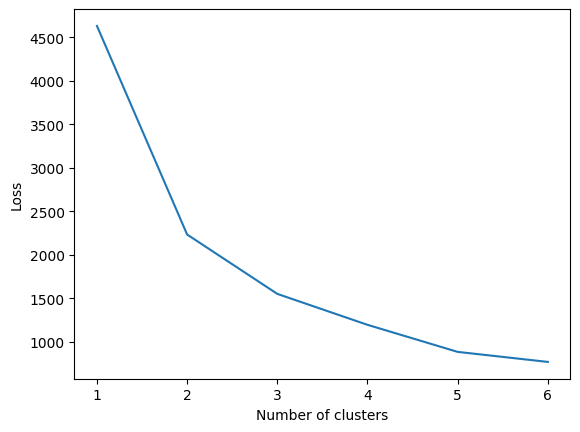

In [ ]:
gridSearch(df_hex_pickup_clust_wd_scaled, 6)

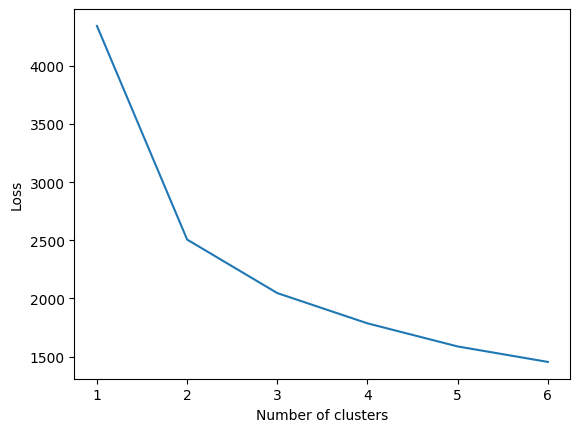

In [ ]:
gridSearch(df_hex_pickup_clust_we_scaled, 6)

According to the elbow chart, the optimal number of clusters is 2.

### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [ ]:
num_cluster = 2

#### Gaussian Mixture Model

In [ ]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_hex_pickup_clust_wd_scaled, df_hex_pickup_clust_wd)

model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_hex_pickup_clust_we_scaled, df_hex_pickup_clust_we)

In [ ]:
df_hex_pickup_clust_we

start_1_hour      0.0   1.0   2.0   3.0   4.0  5.0  6.0  7.0  8.0  9.0  ...  \
pickup_hex_9                                                            ...   
892664520afffff   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  1.0  1.0  ...   
89266452183ffff   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  3.0  ...   
892664c1007ffff   0.0   0.0   2.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...   
892664c100bffff   0.0   2.0   0.0   0.0   0.0  1.0  0.0  0.0  0.0  0.0  ...   
892664c101bffff   0.0   0.0   1.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...   
...               ...   ...   ...   ...   ...  ...  ...  ...  ...  ...  ...   
89275934333ffff   2.0   0.0   1.0   0.0   0.0  0.0  0.0  0.0  0.0  1.0  ...   
89275934cdbffff   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...   
89275934ed3ffff   1.0   3.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  1.0  ...   
892759369bbffff   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...   
None             19.0  17.0  12.0  12.0  12.0  1.0  2.0  2.0  4.0  6.0  ...   

start_1_hour     15.0  16.0  17.0  18.0  19.0  20.0  21.0  22.0  23.0  \
pickup_hex_9                                                            
892664520afffff   4.0   1.0   1.0   0.0   0.0   1.0   0.0   1.0   0.0   
89266452183ffff   1.0   2.0   1.0   1.0   2.0   2.0   5.0   5.0   1.0   
892664c1007ffff   0.0   0.0   0.0   1.0   0.0   3.0   1.0   2.0   1.0   
892664c100bffff   0.0   0.0   0.0   1.0   0.0   0.0   1.0   2.0   1.0   
892664c101bffff   1.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0   2.0   
...               ...   ...   ...   ...   ...   ...   ...   ...   ...   
89275934333ffff   0.0   3.0   2.0   1.0   1.0   1.0   2.0   2.0   0.0   
89275934cdbffff   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
89275934ed3ffff   3.0   3.0  11.0   4.0   9.0   6.0   4.0   2.0   5.0   
892759369bbffff   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   
None              8.0  10.0   7.0   7.0  11.0   8.0  11.0  14.0   6.0   

start_1_hour     cluster_GaussianMixture  
pickup_hex_9                              
892664520afffff                        1  
89266452183ffff                        1  
892664c1007ffff                        1  
892664c100bffff                        1  
892664c101bffff                        1  
...                                  ...  
89275934333ffff                        1  
89275934cdbffff                        1  
89275934ed3ffff                        0  
892759369bbffff                        1  
None                                   0  

[181 rows x 25 columns]

#### KMeans

In [ ]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_hex_pickup_clust_wd_scaled, df_hex_pickup_clust_wd)

model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_hex_pickup_clust_we_scaled, df_hex_pickup_clust_we)

In [ ]:
df_hex_pickup_clust_we

start_1_hour      0.0   1.0   2.0   3.0   4.0  5.0  6.0  7.0  8.0  9.0  ...  \
pickup_hex_9                                                            ...   
892664520afffff   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  1.0  1.0  ...   
89266452183ffff   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  3.0  ...   
892664c1007ffff   0.0   0.0   2.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...   
892664c100bffff   0.0   2.0   0.0   0.0   0.0  1.0  0.0  0.0  0.0  0.0  ...   
892664c101bffff   0.0   0.0   1.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...   
...               ...   ...   ...   ...   ...  ...  ...  ...  ...  ...  ...   
89275934333ffff   2.0   0.0   1.0   0.0   0.0  0.0  0.0  0.0  0.0  1.0  ...   
89275934cdbffff   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...   
89275934ed3ffff   1.0   3.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  1.0  ...   
892759369bbffff   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...   
None             19.0  17.0  12.0  12.0  12.0  1.0  2.0  2.0  4.0  6.0  ...   

start_1_hour     16.0  17.0  18.0  19.0  20.0  21.0  22.0  23.0  \
pickup_hex_9                                                      
892664520afffff   1.0   1.0   0.0   0.0   1.0   0.0   1.0   0.0   
89266452183ffff   2.0   1.0   1.0   2.0   2.0   5.0   5.0   1.0   
892664c1007ffff   0.0   0.0   1.0   0.0   3.0   1.0   2.0   1.0   
892664c100bffff   0.0   0.0   1.0   0.0   0.0   1.0   2.0   1.0   
892664c101bffff   0.0   1.0   0.0   0.0   0.0   1.0   0.0   2.0   
...               ...   ...   ...   ...   ...   ...   ...   ...   
89275934333ffff   3.0   2.0   1.0   1.0   1.0   2.0   2.0   0.0   
89275934cdbffff   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
89275934ed3ffff   3.0  11.0   4.0   9.0   6.0   4.0   2.0   5.0   
892759369bbffff   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   
None             10.0   7.0   7.0  11.0   8.0  11.0  14.0   6.0   

start_1_hour     cluster_GaussianMixture  cluster_KMeans  
pickup_hex_9                                              
892664520afffff                        1               0  
89266452183ffff                        1               0  
892664c1007ffff                        1               0  
892664c100bffff                        1               0  
892664c101bffff                        1               0  
...                                  ...             ...  
89275934333ffff                        1               0  
89275934cdbffff                        1               0  
89275934ed3ffff                        0               1  
892759369bbffff                        1               0  
None                                   0               1  

[181 rows x 26 columns]

#### Evaluation

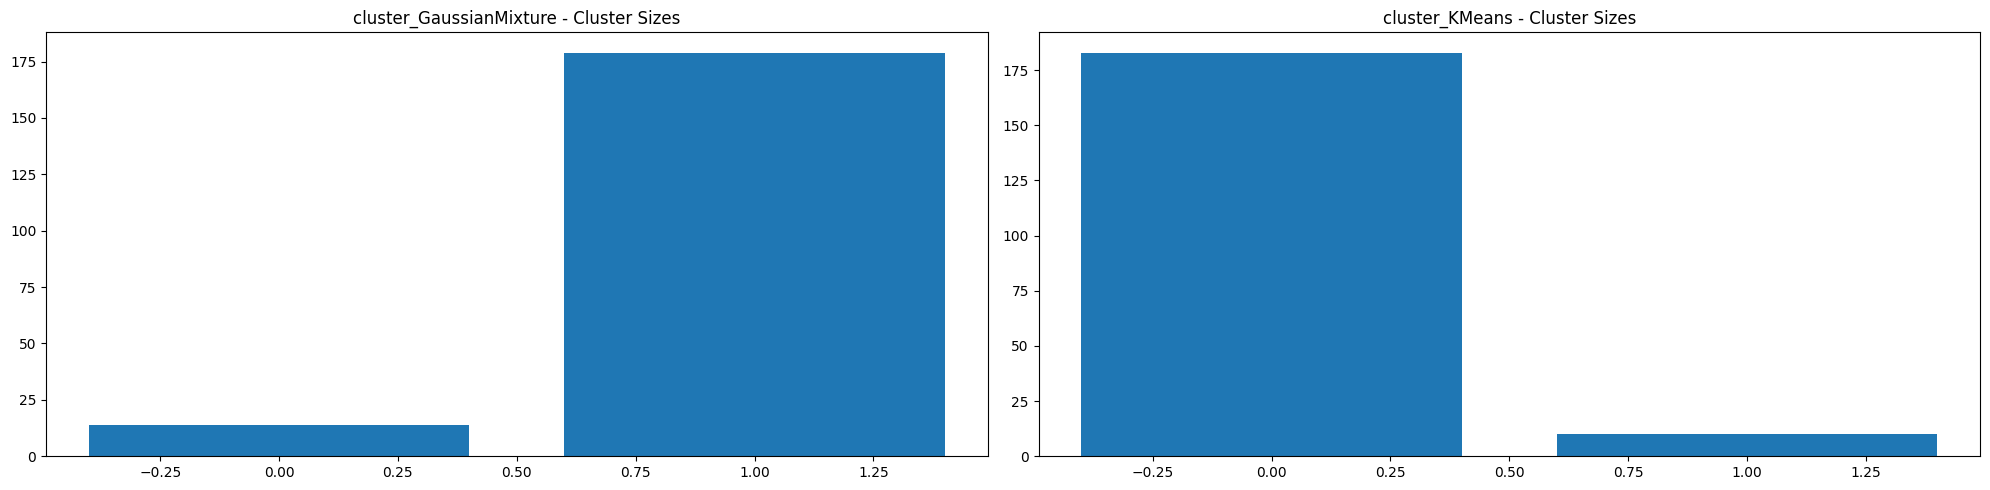

In [ ]:
plt_cluster_size(df_hex_pickup_clust_wd)

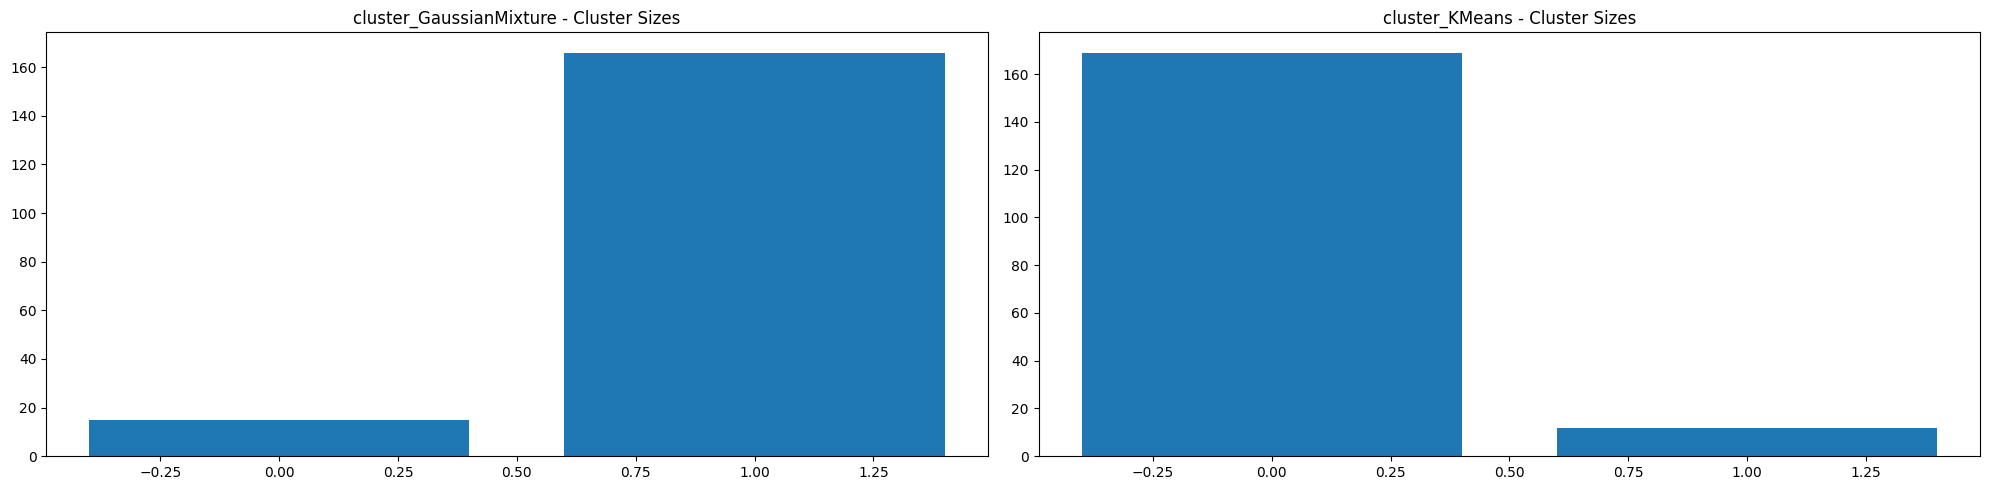

In [ ]:
plt_cluster_size(df_hex_pickup_clust_we)

['cluster_GaussianMixture', 'cluster_KMeans']
0 0 cluster_GaussianMixture
1 0 cluster_KMeans
0 1 cluster_GaussianMixture
1 1 cluster_KMeans


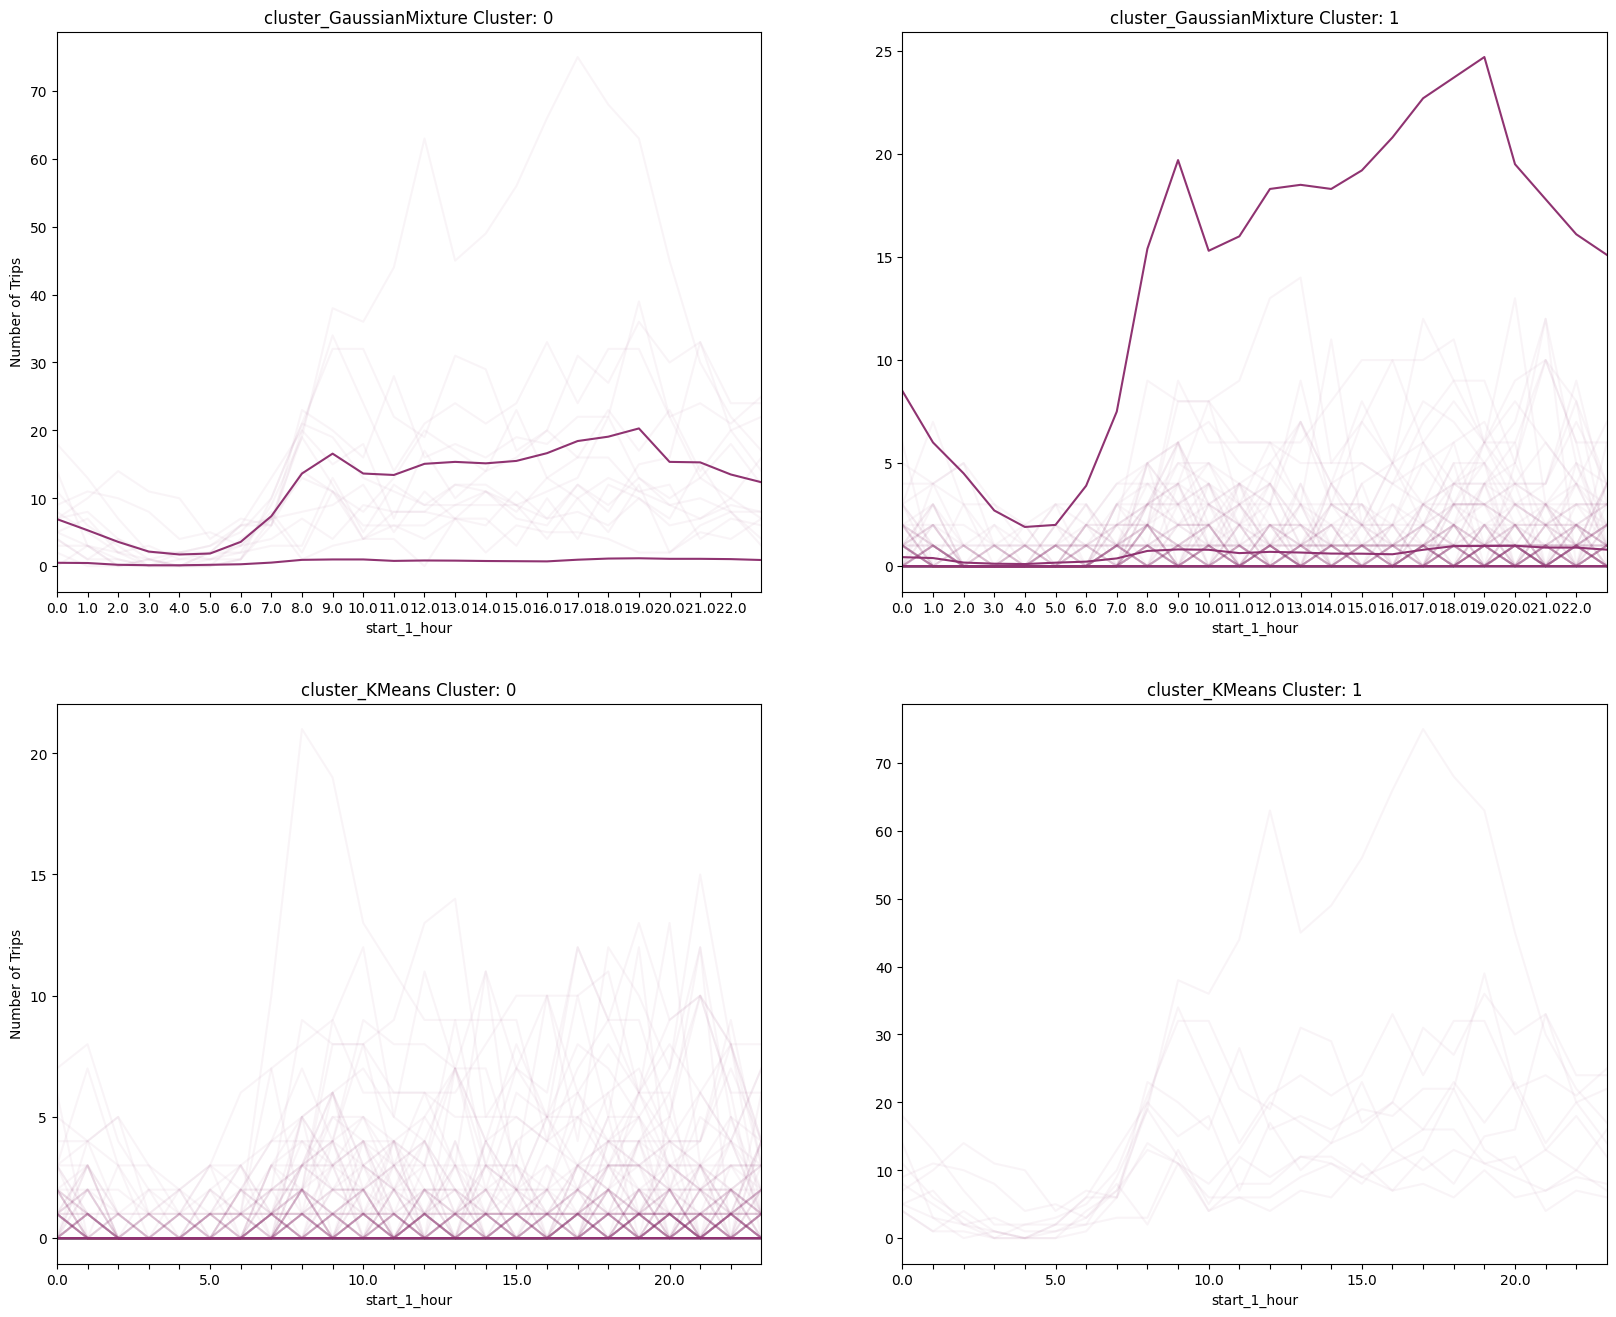

In [ ]:
plt_temporal_patterns(df_hex_pickup_clust_wd, num_cluster)

['cluster_GaussianMixture', 'cluster_KMeans']
0 0 cluster_GaussianMixture
1 0 cluster_KMeans
0 1 cluster_GaussianMixture
1 1 cluster_KMeans


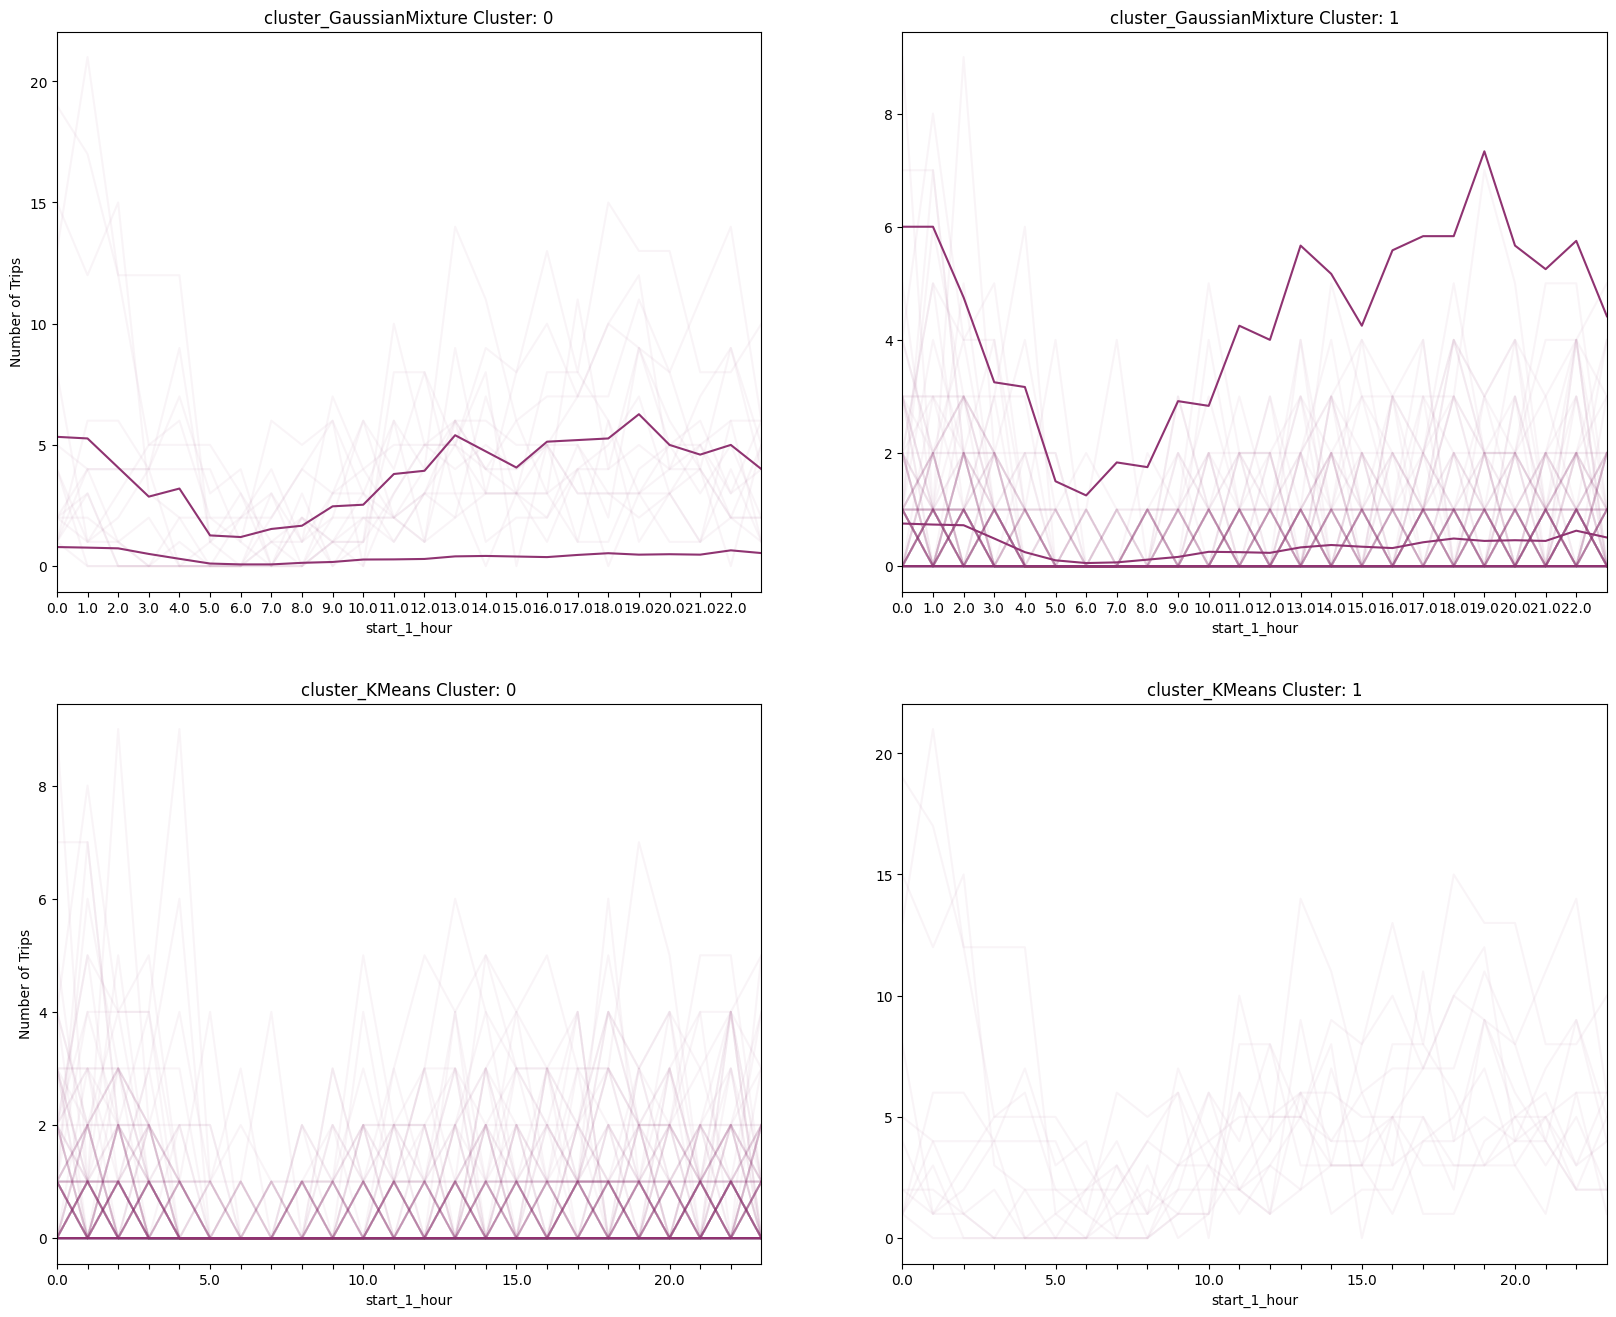

In [ ]:
plt_temporal_patterns(df_hex_pickup_clust_we, num_cluster)

In [ ]:
df_hex_pickup_clust_unified = df_hex_pickup_clust_wd.join(df_hex_pickup_clust_we, how='outer', lsuffix='_weekday', rsuffix='_weekend')

In [ ]:
hex_to_map(df_hex_pickup_clust_unified)

## Hexagon hotspot

Clustering based on same features as trip clustering enhanced by weather feature

In [ ]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0    2014-01-21 08:00:00          1.0              1           0.781831   
1    2014-02-01 22:00:00          2.0              5          -0.974928   
2    2014-11-14 23:00:00         11.0              4          -0.433884   
3    2014-03-16 11:00:00          3.0              6          -0.781831   
4    2014-03-21 22:00:00          3.0              4          -0.433884   
...                  ...          ...            ...                ...   
9995 2014-06-19 07:00:00          6.0              3           0.433884   
9996 2014-05-18 18:00:00          5.0              6          -0.781831   
9997 2014-05-16 23:00:00          5.0              4          -0.433884   
9998 2014-10-28 12:00:00         10.0              1           0.781831   
9999 2014-12-11 11:00:00         12.0              3           0.433884   

      start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0              0.623490           8.0      8.660254e-01     -5.000000e-01   
1             -0.222521          22.0     -5.000000e-01      8.660254e-01   
2             -0.900969          23.0     -2.588190e-01      9.659258e-01   
3              0.623490          11.0      2.588190e-01     -9.659258e-01   
4             -0.900969          22.0     -5.000000e-01      8.660254e-01   
...                 ...           ...               ...               ...   
9995          -0.900969           7.0      9.659258e-01     -2.588190e-01   
9996           0.623490          18.0     -1.000000e+00     -1.836970e-16   
9997          -0.900969          23.0     -2.588190e-01      9.659258e-01   
9998           0.623490          12.0      1.224647e-16     -1.000000e+00   
9999          -0.900969          11.0      2.588190e-01     -9.659258e-01   

      Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0            840.0        9.75  892664c1eabffff  892664c1e73ffff   
1           1108.0       15.25  892664ca913ffff  892664c80afffff   
2            600.0       10.65  892664c1e0fffff  892664c114fffff   
3              0.0        3.25  892664c1acfffff  892664c1acfffff   
4            360.0        7.55  892664c1e13ffff  892664c1e0fffff   
...            ...         ...              ...              ...   
9995         780.0       14.05  892664c1607ffff  892664c1ecfffff   
9996         249.0        8.05  892664cad77ffff  892664c1a8bffff   
9997         300.0        6.45  892664c1633ffff  892664c105bffff   
9998         480.0       10.65  892664c1b6fffff  892664c1ab3ffff   
9999         540.0       14.46  892664ca913ffff  892664c8cabffff   

      Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                   1.0                       0.0                   6   
1                   1.0                       0.0                   8   
2                   1.0                       0.0                   4   
3                   1.0                       0.0                   2   
4                   1.0                       0.0                   6   
...                 ...                       ...                 ...   
9995                1.0                       0.0                  25   
9996                0.0                       1.0                   7   
9997                1.0                       0.0                  24   
9998                0.0                       1.0                  12   
9999                0.0                       1.0                   8   

      dist_center_dropoff  direction  is_weekend  
0                       4         -2           0  
1                      32         24           1  
2                      12          8           0  
3                       2          0           1  
4                       4         -2           0  
...                   ...        ...         ...  
9995                    7        -18           0  
9996                    0         -7           1  
9997                   21     

In [ ]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [ ]:
# Aggregate trips based hexagon ID
df_hex_demand_clust = pd.DataFrame(df_trips.groupby(by=[f'pickup_hex_{HEX_RES}']).count()['ts_start_1_hour'])
df_hex_demand_clust.rename(columns={'ts_start_1_hour':'demand'}, inplace=True)
df_hex_demand_clust['hex'] =  df_hex_demand_clust.index

# add geometry
df_hex_demand_clust['geometry_lat'] = df_hex_demand_clust['hex'].apply(lambda id: h3.cell_to_latlng(id)[0])
df_hex_demand_clust['geometry_lon'] = df_hex_demand_clust['hex'].apply(lambda id: h3.cell_to_latlng(id)[1])

df_hex_demand_clust.drop(columns='hex', inplace=True)


df_hex_demand_clust

demand  geometry_lat  geometry_lon
pickup_hex_9                                       
89266419493ffff       1     41.706603    -87.536490
892664520afffff      32     41.792284    -87.768647
89266452147ffff       1     41.778974    -87.766337
89266452183ffff     114     41.786684    -87.751264
892664c1007ffff      23     41.929572    -87.635695
...                 ...           ...           ...
892664d9bcbffff      10     41.978052    -87.769760
89275934333ffff      79     41.980902    -87.915101
89275934cdbffff       1     41.983699    -87.878301
89275934ed3ffff     331     41.979888    -87.903647
892759369bbffff       4     41.984051    -87.802899

[217 rows x 3 columns]

Scale encoded dataframe

In [ ]:
df_hex_demand_clust_scaled = scale_df(df_hex_demand_clust)

Calculate the optimal number of clusters using a Grid Search

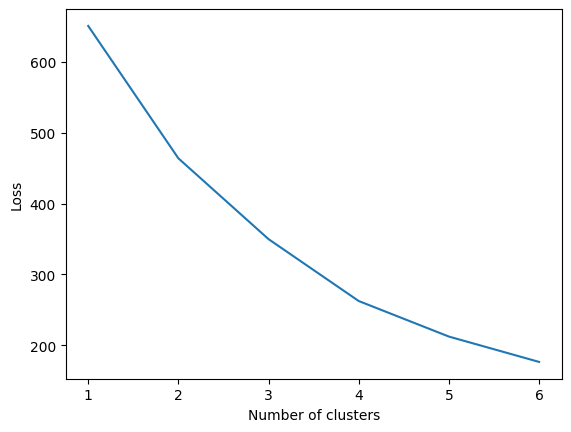

In [ ]:
gridSearch(df_hex_demand_clust_scaled, 6)

According to the elbow chart, the optimal number of clusters is 2.

### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [ ]:
num_cluster = 3

#### Gaussian Mixture Model

In [ ]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_hex_demand_clust_scaled, df_hex_demand_clust)

In [ ]:
df_hex_demand_clust

demand  geometry_lat  geometry_lon  cluster_GaussianMixture
pickup_hex_9                                                                
89266419493ffff       1     41.706603    -87.536490                        0
892664520afffff      32     41.792284    -87.768647                        0
89266452147ffff       1     41.778974    -87.766337                        0
89266452183ffff     114     41.786684    -87.751264                        0
892664c1007ffff      23     41.929572    -87.635695                        1
...                 ...           ...           ...                      ...
892664d9bcbffff      10     41.978052    -87.769760                        0
89275934333ffff      79     41.980902    -87.915101                        0
89275934cdbffff       1     41.983699    -87.878301                        0
89275934ed3ffff     331     41.979888    -87.903647                        0
892759369bbffff       4     41.984051    -87.802899                        0

[217 rows x 4 columns]

In [ ]:
feature_distribution(df_hex_demand_clust, f'cluster_{model.__class__.__name__}')

demand             geometry_lat            \
                               mean         std         mean       std   
cluster_GaussianMixture                                                  
0                         59.000000   75.281113    41.888100  0.077909   
1                          7.685714    7.934159    41.929287  0.038147   
2                        254.866667  234.461348    41.896526  0.007882   

                        geometry_lon           cluster_size first_demand  \
                                mean       std                             
cluster_GaussianMixture                                                    
0                         -87.680230  0.078580           62            1   
1                         -87.669570  0.024073          140            1   
2                         -87.626182  0.006408           15           59   

                        first_geometry_lat first_geometry_lon  
                                                               
cluster_GaussianMixture                                        
0                                41.706603         -87.536490  
1                                41.929572         -87.635695  
2                                41.906442         -87.625680

#### KMeans

In [ ]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_hex_demand_clust_scaled, df_hex_demand_clust)

In [ ]:
df_hex_demand_clust

demand  geometry_lat  geometry_lon  cluster_GaussianMixture  \
pickup_hex_9                                                                   
89266419493ffff       1     41.706603    -87.536490                        0   
892664520afffff      32     41.792284    -87.768647                        0   
89266452147ffff       1     41.778974    -87.766337                        0   
89266452183ffff     114     41.786684    -87.751264                        0   
892664c1007ffff      23     41.929572    -87.635695                        1   
...                 ...           ...           ...                      ...   
892664d9bcbffff      10     41.978052    -87.769760                        0   
89275934333ffff      79     41.980902    -87.915101                        0   
89275934cdbffff       1     41.983699    -87.878301                        0   
89275934ed3ffff     331     41.979888    -87.903647                        0   
892759369bbffff       4     41.984051    -87.802899                        0   

                 cluster_KMeans  
pickup_hex_9                     
89266419493ffff               1  
892664520afffff               1  
89266452147ffff               1  
89266452183ffff               1  
892664c1007ffff               0  
...                         ...  
892664d9bcbffff               0  
89275934333ffff               0  
89275934cdbffff               0  
89275934ed3ffff               2  
892759369bbffff               0  

[217 rows x 5 columns]

In [ ]:
feature_distribution(df_hex_demand_clust, f'cluster_{model.__class__.__name__}')

demand             geometry_lat           geometry_lon  \
                      mean         std         mean       std         mean   
cluster_KMeans                                                               
0                13.105634   21.873819    41.944185  0.028607   -87.682133   
1                39.406250   51.810313    41.853097  0.050287   -87.643917   
2               379.454545  194.504171    41.903442  0.030976   -87.657566   

                         cluster_size first_demand first_geometry_lat  \
                     std                                                
cluster_KMeans                                                          
0               0.042244          142            1          41.929572   
1               0.041349           64            1          41.706603   
2               0.082234           11          253          41.945618   

               first_geometry_lon  
                                   
cluster_KMeans                     
0                      -87.635695  
1                      -87.536490  
2                      -87.656641

#### Evaluation

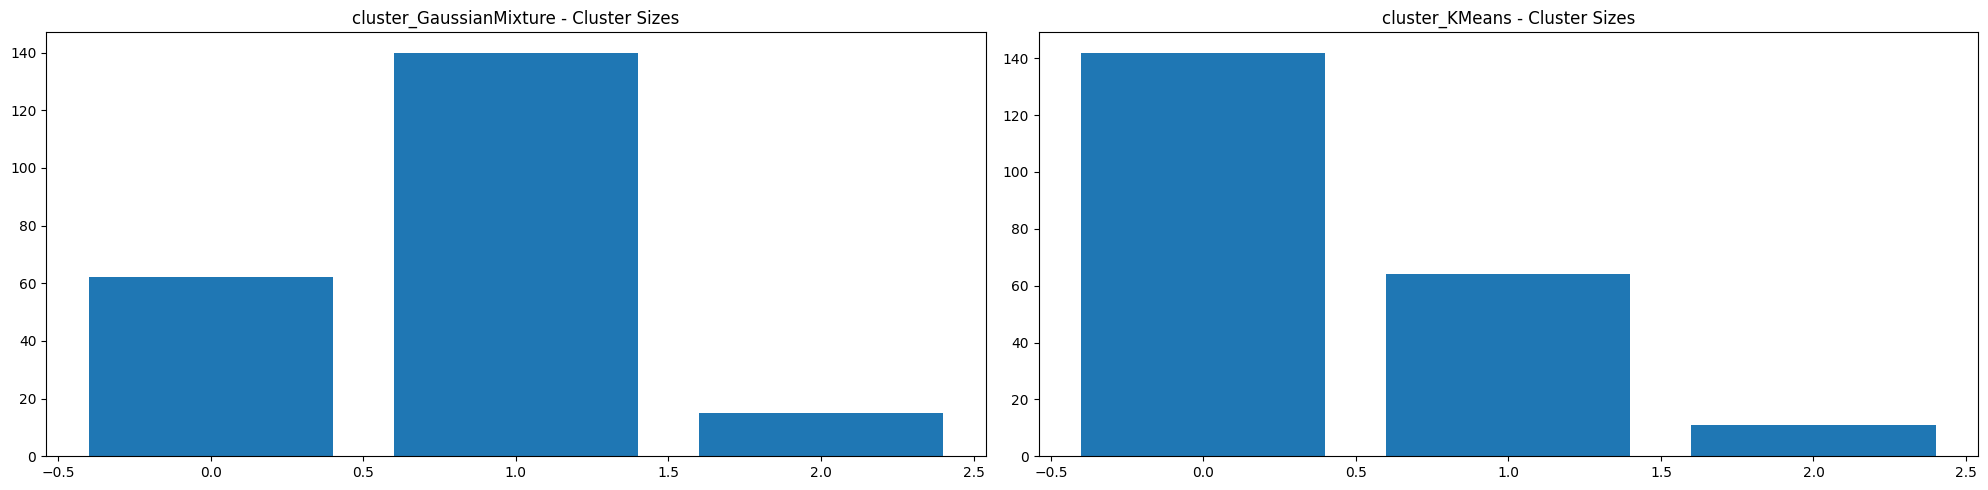

In [ ]:
plt_cluster_size(df_hex_demand_clust)

In [ ]:
hex_to_map(df_hex_demand_clust)